Requirements:

* LabOne Version >= 22.08
* Instruments:
    1 x SHFQC Instrument
<!-- #endregion -->

# Import packages and connect instruments

In [13]:
%matplotlib notebook
from zhinst.toolkit import Session, SHFQAChannelMode, CommandTable, Waveforms
from zhinst.utils.shfqa import SHFQA_SAMPLING_FREQUENCY

import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pylab import rcParams
import random

from scipy.signal import gaussian
from scipy.linalg import expm

session = Session("10.42.11.6")
device = session.connect_device("DEV12108")
fs = 2e9 # sampling frequency of QA channel
device_type = device.device_type

# Predefined functions

In [38]:
def seqc_resonator_spec_shfqa(f_start, f_stop, num_points, avg_mode, num_avgs, integration_time):
    integration_length = int(fs*integration_time/4)*4
    if num_points == 1:
        f_step = 0
    else:
        f_step = (f_stop - f_start)/(num_points - 1)
    if avg_mode == 1: # sequential
        n = num_points
        m = num_avgs
        sweep_str = 'setSweepStep(OSC0, i);'
    else:
        n = num_avgs
        m = num_points
        sweep_str = 'setSweepStep(OSC0, j);'
    
    seqc_program = f'''
   
    const OSC0 = 0;
    setTrigger(0);
    configFreqSweep(OSC0, {f_start}, {f_step});
    waitDigTrigger(1);

    for(var i = 0; i < {n}; i++) {{
        for(var j = 0; j < {m}; j++) {{
            // self-triggering mode

            // define time from setting the oscillator frequency to sending
            // the spectroscopy trigger
            playZero(400);

            // set the oscillator frequency depending on the loop variable i
            {sweep_str}
            resetOscPhase();

            // define time to the next iteration
            playZero({integration_length} + 144);

            // trigger the integration unit and pulsed playback in pulsed mode
            setTrigger(1);
            setTrigger(0);

        }}
    }}
    '''
    return seqc_program

def envelope_pulsed_spectroscopy(envelope_duration = 10e-6, envelope_rise_fall_time = 50e-9, do_plot = 0):

    rise_fall_len = int(envelope_rise_fall_time * fs)
    std_dev = rise_fall_len // 10 
    envelope_samples = int(envelope_duration * fs)
    t = np.linspace(0, envelope_duration, envelope_samples)*1e6 # in units of μs
    gauss = gaussian(2 * rise_fall_len, std_dev)

    flat_top_gaussian = np.ones(envelope_samples)*(1-1j)/np.sqrt(2)
    flat_top_gaussian[0:rise_fall_len] = gauss[0:rise_fall_len]*(1-1j)/np.sqrt(2)
    flat_top_gaussian[-rise_fall_len:] = gauss[-rise_fall_len:]*(1-1j)/np.sqrt(2)

    if do_plot == 1:    
        plt.figure()
        plt.plot(t, flat_top_gaussian.real, label = 'real')
        plt.plot(t, flat_top_gaussian.imag, label = 'imag')
        plt.xlabel('Time (μs)')
        plt.ylabel('Amplitude (arb. unit)')
        plt.tight_layout()
        plt.show()
    return flat_top_gaussian * (1 + 0j)

def upload_generate_readout_pulses(device, pulse_duration, rise_fall_time, f_start, phase, num_qubits, scaling):
    
    rise_fall_len = int(rise_fall_time * fs)
    pulse_len = int(pulse_duration * fs)
    std_dev = rise_fall_len // 10
    gauss = gaussian(2 * rise_fall_len, std_dev)
    flat_top_gaussian = np.ones(pulse_len)
    flat_top_gaussian[0:rise_fall_len] = gauss[0:rise_fall_len]
    flat_top_gaussian[-rise_fall_len:] = gauss[-rise_fall_len:]
    flat_top_gaussian *= scaling
    time_vec = np.linspace(0, pulse_duration, pulse_len)

    readout_pulses = Waveforms()
    for i, f in enumerate(f_start):
        readout_pulses.assign_waveform(
            slot=i,
            wave1=flat_top_gaussian * np.exp(2j * np.pi * f * time_vec + 2j * np.pi * phase)
        )
    device.qachannels[0].generator.write_to_waveform_memory(readout_pulses)
    return readout_pulses

def generate_upload_drive_drag_pulses(pulse_duration, pulse_sigma, beta, amp, upload = False, 
                                      device = 'dev12131', channel_index = 0, exp = 'qubit spec',
                                      start = 0, stop = 1, num_points = 2):
    if 'rabi dt' not in exp:
        pulse_duration_samples = int(pulse_duration * fs/16)*16
        pulse_sigma_samples = int(pulse_sigma * fs/16)*16
        drive_pulse = Waveforms()
        drive_pulse.assign_waveform(
            slot = 0,
            wave1 = amp * gaussian(pulse_duration_samples, pulse_sigma_samples),
            wave2 = beta * np.concatenate((np.array([0]), np.diff(amp * gaussian(pulse_duration_samples, pulse_sigma_samples))),  axis=None)
            )
    if 'rabi dt' in exp:
        ratio_pulse_sigma = pulse_duration/pulse_sigma
        drive_pulse = Waveforms()
        for i in range(num_points):
            pulse_duration_i = start + (stop-start)/(num_points-1)*i
            pulse_duration_samples = int(pulse_duration_i * fs/16)*16
            pulse_sigma_samples = int(pulse_duration_i/ratio_pulse_sigma * fs/16)*16
            drive_pulse.assign_waveform(
                slot = i,
                wave1 = amp * gaussian(pulse_duration_samples, pulse_sigma_samples),
                wave2 = beta * np.concatenate((np.array([0]), np.diff(amp * gaussian(pulse_duration_samples, pulse_sigma_samples))),  axis=None)
                )
    if upload is True:
        device.sgchannels[channel_index].awg.write_to_waveform_memory(drive_pulse)
        time.sleep(2)
    return drive_pulse

def seqc_qubit_exp_qa(num_points = 1, num_avgs = 1, delay_after_trigger = 5e-6):
    delay_sample = int(delay_after_trigger * fs/16)*16
    seqc_program = f'''
    repeat({int(num_points*num_avgs)}){{
        waitDigTrigger(1);
        playZero({delay_sample});
        playZero(32);
        startQA(QA_GEN_ALL, QA_INT_ALL, true);
    }}
    '''
    return seqc_program
    
def upload_compile_seqc_sg(start = 0, stop = 0, num_points = 1, num_avgs = 1, avg_mode = 0, dr_pulse_duration = 100e-9,\
            delay_after_trigger = 1e-6, n_cpmg = 1, exp = 'qubit spec', upload_compile = False, device = 'dev12131', channel_index = 0):
    
    step = (stop - start)/(num_points - 1) if num_points is not 1 else 0
    start_sample = int(start * fs / 16) * 16
    stop_sample = int(stop * fs / 16) * 16
    step_sample = int(step * fs / 16) * 16
        
    if avg_mode == 0:
        avg_str = f'''
          for (i = 0; i < {num_avgs}; i = i + 1){{
              for (j = 0; j < {num_points}; j = j + 1){{
              '''
    else:
        avg_str = f'''          
          for (j = 0; j < {num_points}; j = j + 1){{
              for (i = 0; i < {num_avgs}; i = i + 1){{
              '''     
    dr_pulse_sample = int(dr_pulse_duration * fs/16)*16
    delay_sample = int(delay_after_trigger * fs/16)*16
    waveforms_def = f'''assignWaveIndex(1,2,placeholder({dr_pulse_sample}),1,2, placeholder({dr_pulse_sample}), 0);\n'''
    
    seqc_common = f'''
        {waveforms_def}
    '''
    if 'qubit spec' in exp:
        wait_samples = int((delay_sample-dr_pulse_sample)/16)*16
        if exp == 'qubit spec pulsed':
            pulse_str = f'''                  
            playZero({wait_samples});
            executeTableEntry(0);
            '''
        else: 
            assign_waveforms = ''
            pulse_str = ''
            seqc_common = ''
            
        seqc_main = f'''
            const osc = 0;
            const f_start = {start};
            const f_stop = {stop};
            

            configFreqSweep(osc, f_start, {step});
            var i, j;
            {avg_str}
            waitDigTrigger(1);
            resetOscPhase();
            setSweepStep(osc, j);
            {pulse_str}
              }}
            }} 
        '''
    else:
        if avg_mode is 1:
            print('average mode is set to cyclic')
    if 'rabi da' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                waitDigTrigger(1);
                resetOscPhase();
                playZero({wait_samples});
                executeTableEntry(0);
                for (j = 0; j < {num_points-1}; j++){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples});
                    executeTableEntry(1);
                }}
            }}'''
    if 'rabi dt' in exp:
        seqc_common = ''
        waveforms_def = ''
        for i in range(num_points):
            waveforms_def += f'''assignWaveIndex(1,2,placeholder({start_sample+step_sample*i}),1,2, placeholder({start_sample+step_sample*i}), {i});\n'''
        wait_samples = int((delay_after_trigger - start) * fs/16)*16
        seqc_main = f'''
            {waveforms_def}
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = 0; j < {num_points}; j++){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-{step_sample}*j);
                    executeTableEntry(j);
                }}
            }}'''
    if 't1' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = {start_sample}; j <= {stop_sample}; j = j + {step_sample}){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-j);
                    executeTableEntry(1);
                }}
            }}'''
        
    if 'ramsey' in exp:
        wait_samples = int((delay_after_trigger - 2 * dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = {start_sample}; j <={stop_sample}; j = j + {step_sample}){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-j);
                    executeTableEntry(0);
                    playZero(j);
                    executeTableEntry(0);
                }}
            }}'''
    if 'hanh echo' in exp:
        wait_samples = int((delay_after_trigger - 3 * dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = {start_sample}; j <= {stop_sample}; j = j + {step_sample}){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-2*j);
                    executeTableEntry(1);
                    playZero(j);
                    executeTableEntry(0);
                    playZero(j);
                    executeTableEntry(1);
                }}
            }}''' 
    if 'cpmg' in exp:
        wait_samples = int((delay_after_trigger - (2+n_cpmg) * dr_pulse_duration) * fs/16)*16
        seqc_main = f'''            
            var i, j;
            for (i = 0; i < {num_avgs}; i++){{
                for (j = {start_sample}; j <= {stop_sample}; j = j + {step_sample}){{
                    waitDigTrigger(1);
                    resetOscPhase();
                    playZero({wait_samples}-2*{n_cpmg}*j);
                    executeTableEntry(1);
                    repeat({n_cpmg}){{
                        playZero(j);
                        executeTableEntry(0);
                        playZero(j);
                    }}
                    executeTableEntry(1);
                }}
            }}'''
    if 'weights 2-state' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''
        var i, j;
        for (j = 0; j < 4; j = j + 2){{
            for (i = 0; i < {num_avgs}; i++){{
                waitDigTrigger(1);
                resetOscPhase();
                playZero({wait_samples});
                executeTableEntry(2-j);
            }}
        }}
        '''
    if 'thresholds 2-state' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''
        var i, j;
        var k = 0;
        for (j = 0; j < {num_points}; j = j + 1){{
            if (j < {int(num_points/2)}){{
                var k = 2;
                }}
            waitDigTrigger(1);
            resetOscPhase();
            playZero({wait_samples});
            executeTableEntry(k);
        }}
        '''
    if 'assignment fidelity 2-state' in exp:
        wait_samples = int((delay_after_trigger - dr_pulse_duration) * fs/16)*16
        seqc_main = f'''
        var i, j;
        for (j = 0; j < {int(num_points/2)}; j = j + 1){{
            for (i = 0; i < {num_avgs}; i = i + 1){{
                waitDigTrigger(1);
                resetOscPhase();
                playZero({wait_samples});
                executeTableEntry(2);
                waitDigTrigger(1);
                resetOscPhase();
                playZero({wait_samples});
                executeTableEntry(0);
            }}
        }}
        '''        
        
    if upload_compile is True:
        elf_file, info = device.sgchannels[channel_index].awg.compile_sequencer_program(seqc_common + seqc_main)
        device.sgchannels[channel_index].awg.elf.data(elf_file)
    return  seqc_common + seqc_main

def upload_ct_sg(start=0, stop=1, num_points=2, exp = 'qubit spec pulsed', upload = True, 
                 device = 'dev12131', channel_index = 0):
    
    step = (stop - start)/(num_points - 1) if num_points is not 1 else 0
    ct = CommandTable(device.sgchannels[channel_index].awg.commandtable.load_validation_schema())
    if 'qubit spec pulsed' in exp or 'ramsey' in exp or 't1' in exp or 'hanh echo' in exp or 'cpmg' in exp or 'weights 2-state' in exp or 'thresholds 2-state' in exp or 'assignment fidelity 2-state' in exp:
        ct.table[0].waveform.index = 0
        ct.table[0].amplitude00.value = 1; ct.table[0].amplitude00.increment = False
        ct.table[0].amplitude01.value = -1; ct.table[0].amplitude01.increment = False
        ct.table[0].amplitude10.value = 1; ct.table[0].amplitude10.increment = False
        ct.table[0].amplitude11.value = 1; ct.table[0].amplitude11.increment = False
        ct.table[1].waveform.index = 0
        ct.table[1].amplitude00.value = 0.5; ct.table[0].amplitude00.increment = False
        ct.table[1].amplitude01.value = -0.5; ct.table[0].amplitude01.increment = False
        ct.table[1].amplitude10.value = 0.5; ct.table[0].amplitude10.increment = False
        ct.table[1].amplitude11.value = 0.5; ct.table[0].amplitude11.increment = False
        ct.table[2].waveform.index = 0
        ct.table[2].amplitude00.value = 0; ct.table[0].amplitude00.increment = False
        ct.table[2].amplitude01.value = -0; ct.table[0].amplitude01.increment = False
        ct.table[2].amplitude10.value = 0; ct.table[0].amplitude10.increment = False
        ct.table[2].amplitude11.value = 0; ct.table[0].amplitude11.increment = False        
        
    if 'rabi da' in exp:
        if stop > 1:
            print('amplitude scaling factor > 1 is invalid') 
        ct.table[0].waveform.index = 0
        ct.table[0].amplitude00.value = start; ct.table[0].amplitude00.increment = False
        ct.table[0].amplitude01.value = -start; ct.table[0].amplitude01.increment = False
        ct.table[0].amplitude10.value = start; ct.table[0].amplitude10.increment = False
        ct.table[0].amplitude11.value = start; ct.table[0].amplitude11.increment = False
        ct.table[1].waveform.index = 0
        ct.table[1].amplitude00.value = step; ct.table[1].amplitude00.increment = True
        ct.table[1].amplitude01.value = -step; ct.table[1].amplitude01.increment = True
        ct.table[1].amplitude10.value = step; ct.table[1].amplitude10.increment = True
        ct.table[1].amplitude11.value = step; ct.table[1].amplitude11.increment = True 
    
    if 'rabi dt' in exp:
        for i in range(num_points):
            ct.table[i].waveform.index = i
        
    device.sgchannels[channel_index].awg.commandtable.upload_to_device(ct)
    
    return ct

def calc_fidelity_matrix_2states(expected_results, readout_results, num_states):
    matrix = np.zeros((num_states,num_states))
    for j in range(num_points):
        matrix[int(readout_results[j])][int(expected_results[j])] = matrix[int(readout_results[j])][int(expected_results[j])] + 1
    return matrix/len(expected_results)*num_states

def plot_fidelity_matrix(matrix, title=None):
    fig, ax = plt.subplots()
    min_val, max_val = 0, 5
    ax.matshow(matrix, cmap="Blues")
    for iy, ix in np.ndindex(matrix.shape):
        value = matrix[iy, ix]
        color = "black" if value < 0.5 else "white"
        ax.text(ix, iy, f"{value:0.3f}", va="center", ha="center", color=color)
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_ylabel("Measured state")
    ax.set_xlabel("Expected state")
    ax.xaxis.set_label_position('top') 
    plt.tight_layout()
    if title:
        plt.title(title)
    plt.show()

def plot_sweeper(f, result, unwrap = True, deg = True):
    f = f/1e9
    power = 10*np.log10(np.abs(result)**2/50*1000)
    phase = np.unwrap(np.angle(result, deg = deg)) if unwrap is True else np.angle(result, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    ax0.plot(f, power, '.-', color = 'steelblue', label = 'power')
    ax0.legend(loc='upper left')
    ax0.set_ylabel('Power (dBm)')
    ax1.plot(f, phase, '.-', color = 'orange', label = 'phase')
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Frequency (GHz)')
    fig.align_ylabels([ax0, ax1])
    ax0.grid()
    ax1.grid()
    ax1.set_ylabel(f'Phase ({phase_unit})')
    plt.tight_layout()
    plt.show()

def plot_2d(x, y, z):
    x0 = np.zeros(len(x)+1)    
    x0[:-1] = x - (x[1]-x[0])/2
    x0[-1]= x[-1] + (x[1]-x[0])/2    
    y0 = np.zeros(len(y)+1)
    y0[:-1] = y - (y[1]-y[0])/2
    y0[-1]= y[-1] + (y[1]-y[0])/2
    
    z_abs = 10*np.log10(np.abs(z)**2/50*1000)
    z_angle = np.angle(z, deg = True)
    X, Y = np.meshgrid(x0 ,y0)
    
    fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
    c0 = ax0.pcolormesh(X, Y,z_abs)
    ax0.set_yticks(y)
    ax0.set_ylabel('Gain')
    ax0.set_title('Power (dBm)')
    fig.colorbar(c0, ax=ax0)

    c1 = ax1.pcolormesh(X, Y, z_angle)
    ax1.set_yticks(y)
    ax1.set_xlabel('Offset frequency (GHz)')
    ax1.set_ylabel('Gain')
    ax1.set_title('Phase (degree)')
    fig.colorbar(c1, ax=ax1)

    fig.tight_layout()
    plt.show()
    
def plot_readout_IQ(data, num_qubits):
    fig, ax = plt.subplots()
    for i in range(num_qubits):
        ax.scatter(data.real[i], data.imag[i], label = f'qubit {i}')
    ax.set_xlabel('Real (Vrms)')
    ax.set_ylabel('Imag (Vrms)')
    ax.grid()
    ax.legend()
    plt.tight_layout()
    plt.show()
    
def plot_qubit_readout_amp_phase(integration_length, x, ys, exp = 'qubit spec', unwrap = False, deg = True):
    power = 10*np.log10(np.abs(ys/integration_length)**2/50*1000)
    phase = np.unwrap(np.angle(ys/integration_length, deg = deg)) if unwrap is True else np.angle(ys, deg = deg)
    phase_unit = 'deg' if deg is True else 'rad'   
    
    if 'qubit spec' in exp:
        x = x/1e9
        x_label = 'Frequency (GHz)'
    if 'rabi da' in exp:
        x_label = 'Amplitude scaling factor'
    if 'ramsey' in exp or 't1' in exp or 'hanh echo' in exp or 'cpmg' in exp or 'rabi dt' in exp:
        x = x*1e6
        x_label = r'τ (μs)'
    for i in range(len(ys)):
        fig, (ax0, ax1) = plt.subplots(nrows = 2, sharex = True)
        ax0.plot(x[i], power[i], '.-', color = 'steelblue', label = f'power')
        ax0.set_title(f'Qubit {i}')
        ax0.legend(loc='upper left')
        ax0.set_ylabel('Power (dBm)')
        ax1.plot(x[i], phase[i], '.-', color = 'orange', label = f'phase')
        ax1.legend(loc='upper left')
        ax1.set_xlabel(x_label)
        ax1.set_ylabel(f'Phase ({phase_unit})')
        fig.align_ylabels([ax0, ax1])
        ax0.grid()
        ax1.grid()
        plt.tight_layout()
        plt.show()

def plot_2_state_threshold_histogram(readout_results, num_bins, ind_q):
    import scipy as scy
    from scipy.optimize import leastsq
    from scipy.stats import norm
    
    n_shots = int(len(readout_results[ind_q])/2)

    fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))

    g_real = np.real(readout_results[ind_q][0:n_shots])
    g_imag = np.imag(readout_results[ind_q][0:n_shots])
    e_real = np.real(readout_results[ind_q][n_shots::])
    e_imag = np.imag(readout_results[ind_q][n_shots::])
    (g_mu, g_sigma) = norm.fit(g_real)
    (e_mu, e_sigma) = norm.fit(e_real)

    fitfunc  = lambda p, x: p[0]*exp(-0.5*((x-p[1])/p[2])**2)+p[3]
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))

    fig, ax = plt.subplots()
    g_n, g_bins, g_patches = ax.hist(g_real, num_bins, density=1, label = 'state 0', color = 'steelblue')
    e_n, e_bins, e_patches = ax.hist(e_real, num_bins, density=1, label = 'state 1', color = 'orange')

    g_init  = [max(g_n), g_mu, g_sigma, min(g_n)]
    e_init  = [max(e_n), e_mu, e_sigma, min(e_n)]
    mu_g, sigma_g = scy.stats.norm.fit(g_real)
    mu_e, sigma_e = scy.stats.norm.fit(e_real)
    threshold = np.mean([mu_g, mu_e])
    best_fit_line_g = scy.stats.norm.pdf(g_bins, mu_g, sigma_g)
    best_fit_line_e = scy.stats.norm.pdf(e_bins, mu_e, sigma_e)
    
    plt.plot(g_bins, best_fit_line_g, '--', color = 'steelblue')
    plt.plot(e_bins, best_fit_line_e, '--', color = 'orange')
    plt.plot(np.ones(10)*threshold, np.linspace(0, 1.1*max(g_n), 10), '--')
    plt.xlabel('Result after integration before normalization (Vrms)')
    plt.ylabel('Counts')
    plt.title(f'Qubit {ind_q} threshold: {threshold}')
    plt.legend()
    plt.show()
    plt.tight_layout()
    return threshold, mu_g, mu_e
    
def plot_uplaoded_waveform(device, ch_ind, readout_ind, weight_ind, num_samples):
    plt.figure()
    readout_wave = device.qachannels[ch_ind].generator.waveforms[readout_ind].wave()
    weight_wave  = device.qachannels[ch_ind].readout.integration.weights[weight_ind].wave()
    plt.plot(np.real(readout_wave[:num_samples]), '.-', label = 'real readout pulse')
    plt.plot(np.real(weight_wave[:num_samples]), '.-', label = 'real integration weight')
    plt.plot(np.imag(readout_wave[:num_samples]), '.-', label = 'imag readout pulse')
    plt.plot(np.imag(weight_wave[:num_samples]), '.-', label = 'imag integration weight')
    plt.xlabel('Sample points')
    plt.ylabel('Amplitude (arb. unit)')
    plt.legend()
    plt.tight_layout()
    plt.show()
       
def plot_measured_weights(weights):
    plt.figure()
    t = np.linspace(0, (1-len(weights))/fs, len(weights))*1e6
    plt.plot(t, weights.real, '-o', label = 'real')
    plt.plot(t, weights.imag, '.-', label = 'imag')
    plt.legend()
    plt.xlabel('t (μs)')
    plt.ylabel('Amplitude (Vrms)')
    plt.tight_layout()
    plt.show()

def plot_after_thresholding(data, label):
    plt.figure()
    plt.plot(data, '-o', label = label)
    plt.legend()
    plt.xlabel('Sample points')
    plt.ylabel('Discriminated state')
    plt.tight_layout()
    plt.show()

def plot_scope_data(scope_data, trigger_delay):
    n = 2
    if '4' in device_type:
        n = 4
     
    plt.figure()
    for i in range(n): 
        if len(scope_data[i]) > 0:
            x = np.linspace(trigger_delay, trigger_delay + len(scope_data[i])/fs, len(scope_data[i]))
            plt.plot(x/1e-6, scope_data[i].real, '.-', label = f'real part of scope data {i}')
            plt.plot(x/1e-6, scope_data[i].imag, '.-', label = f'imag part of scope data {i}')
    plt.legend()
    plt.xlabel('Time (μs)')
    plt.ylabel('Amplitude (Vrms)')
    plt.tight_layout()
    plt.show()


## For RB sequences 

In [15]:
def pauli(ind = 'x'):
    """pauli matrices
    """
    if ind =='x': res = np.array([[0,1], [1,0]])
    if ind =='y': res = np.array([[0,-1j], [1j,0]])
    if ind =='z': res = np.array([[1,0], [0,-1]])
    return res

def rot_matrix(angle=np.pi, axis='x'):
    """general definition of rotation unitary for a single qubit
    """
    return expm(-1j * angle / 2 * pauli(axis))

def mult_gates(gates, use_linalg=False, tol=20):
    """multiply a variable number of gates / matrices - recursive definition faster for simple 2x2 matrices
    """
    if len(gates) > 1:
        if use_linalg:
            res = np.linalg.multi_dot(gates)
        else:
            res = np.matmul(gates[0], mult_gates(gates[1:], use_linalg=False, tol=tol))
    elif len(gates) == 1:
        res = gates[0]
    
    return res.round(tol)

def glob_phase(phase, dim=2):
    """global phase operator for dimensionality dim
    """
    return np.exp(1j * phase) * np.identity(dim)

def match_up_to_phase(target, gates, dim=2, verbose=False):
    """finds the element of the list gates that best matches the target gate up to a global phase of integer multiples of pi
    """
    # set of global phase operators for integer multiples of pi
    glob_phases = [glob_phase(0, dim), glob_phase(np.pi, dim)]
    # gates up to global phases
    gates_2 = [[mult_gates([gate1, gate2]) for gate2 in glob_phases] for gate1 in gates]
    # index of gate that is closest to target up to global phase (using frobenius norm)
    match_index = np.argmin([np.amin([np.linalg.norm(target - gate) for gate in gates]) for gates in gates_2])
    
    return match_index

# all elements of the Clifford group, according to defintion in arXiv:1410.2338
# define user registers that will be used in the seqC
AWG_REGISTER_M1 = 0 # sequence length 
AWG_REGISTER_SEED = 1 # seed
AWG_REGISTER_RECOVERY = 2 # command table index of the right recovery gate 
AWG_REGISTER_START = 3

clifford_params = [
    ['I'],
    ['Y/2', 'X/2'],
    ['-X/2', '-Y/2'],
    ['X'],
    ['-Y/2', '-X/2'],
    ['X/2', '-Y/2'],
    ['Y'],
    ['-Y/2', 'X/2'],
    ['X/2', 'Y/2'],
    ['X', 'Y'],
    ['Y/2', '-X/2'],
    ['-X/2', 'Y/2'],
    ['Y/2', 'X'],
    ['-X/2'],
    ['X/2', '-Y/2', '-X/2'],
    ['-Y/2'],
    ['X/2'],
    ['X/2', 'Y/2', 'X/2'],
    ['-Y/2', 'X'],
    ['X/2', 'Y'],
    ['X/2', '-Y/2', 'X/2'],
    ['Y/2'],
    ['-X/2', 'Y'],
    ['X/2', 'Y/2', '-X/2']
]

clifford_len = len(clifford_params)

# generate matrix representation of all Clifford gates from elementary gates
elem_gates = {'I': np.array([[1,0],[0,1]]),
              'X': rot_matrix(np.pi, 'x'),
              'Y': rot_matrix(np.pi, 'y'),
              'X/2': rot_matrix(np.pi / 2, 'x'),
              'Y/2': rot_matrix(np.pi / 2, 'y'),
              '-X/2': rot_matrix(-np.pi / 2, 'x'),
              '-Y/2': rot_matrix(-np.pi / 2, 'y')}

clifford_matrices = [[elem_gates[gate] for gate in gates] for gates in clifford_params]
clifford_gates = [mult_gates(matrices) for matrices in clifford_matrices]

def pulse_envelope(amplitude, length, phase, qscale=-1.0, sigma=1/3, sample_rate=2e9, tol=15):
    #sigma = 1/3
    # ensure waveform length is integer multiple of 16
    samples = round(sample_rate * length / 16) * 16
    x = np.linspace(-1, 1, samples)
    # output is complex, where phase later determines the gate rotation axis
    ybare =  np.exp(-x**2 / 2 / sigma**2)*(1 - 1j*qscale*x/sigma**2 * sigma**2)*np.exp(1j * np.deg2rad(phase))
    
    #ybare = np.exp(-x**2 / sigma**2)*(1)*np.exp(1j * np.deg2rad(phase))
    #norm = np.norm(ybare)
    #y = amplitude * ybare/norm
    #y=amplitude*ybare/np.max(np.abs(ybare))*1/np.sqrt(2*np.pi)/sigma
    y=amplitude*ybare
    return y.round(tol)

def generate_clifford_gates(
    pi_amplitude = 1, pi_length = 30e-9, 
    pi2_amplitude = 0.5, pi2_length = 30e-9, 
    qscale = 0):

    # parameters of basic single qubit pulses
    pulses_params = {
        'I': {'amplitude':0.0, 'length': pi_length, 'phase': 0.0, 'qscale': qscale},
        'X': {'amplitude':pi_amplitude, 'length': pi_length, 'phase': 0.0, 'qscale': qscale},
        'Y': {'amplitude':pi_amplitude, 'length': pi_length, 'phase': 90.0, 'qscale': qscale},
        'X/2': {'amplitude':pi2_amplitude, 'length': pi2_length, 'phase': 0.0, 'qscale': qscale},
        'Y/2': {'amplitude':pi2_amplitude, 'length': pi2_length, 'phase': 90.0, 'qscale': qscale},
        '-X/2': {'amplitude':pi2_amplitude, 'length': pi2_length, 'phase': 0.0-180.0, 'qscale': qscale},
        '-Y/2': {'amplitude':pi2_amplitude, 'length': pi2_length, 'phase': 90.0-180.0, 'qscale': qscale},
    }
    
    # calculate complex waveforms for single qubit elementary pulses
    pulses_waves = {pulse_type: pulse_envelope(**pulse_param) for (pulse_type, pulse_param) in pulses_params.items()}
    
    # calculate complex waveforms for each of the Clifford gates
    clifford_waves = [np.concatenate([pulses_waves[i] for i in clifford_gate]) for clifford_gate in clifford_params]
    
    # divide real and complex part of waveforms into I and Q channel outputs
    clifford_waves_real = [(np.real(wave), np.imag(wave)) for wave in clifford_waves]
    
    return clifford_waves, clifford_waves_real

def calculate_inverse_clifford(clifford_list, gates=clifford_gates):
    """Calculates the final recovery clifford gate

    Parameters:
    clifford_list: list
        a list containing the indices of the clifford sequence to be inverted
    gate: list
        a list containing the gates to compare the recovery gate to
    """
    # matrix representation of Clifford sequence
    seq_gate = mult_gates([gates[gate] for gate in clifford_list])
    # recovery gate - inverse of full sequence
    rec_gate = np.linalg.inv(seq_gate)
    # index of recovery gate (up to global phase)
    recovery = int(match_up_to_phase(rec_gate, clifford_gates))
    
    return recovery

def upload_seqc_qa_rb(device, channel_index, num_points = 1, num_avgs = 1):
    seqc_program = f"""
    var i, j;
    for (i = 0; i < {num_avgs}; i = i + 1){{
        for (j = 0; j < {num_points}; j = j + 1){{        
            waitDigTrigger(1);
            startQA(QA_GEN_ALL, QA_INT_ALL, true, 0, 0x0);   
        }}
    }}
    """
    if 'shfqc' in device.type:
        channel_index = 0
    else:
        device.qachannels[channel_index].generator.load_sequencer_program(seqc_program)
#     print('QA seqc program uploaded')
    
def upload_seqc_sg_rb(device, channel_index, clifford_waves, clifford_waves_real, num_points, num_avgs, wait_after_rb = 5e-6):       
    # Waveform definition - allocating the waveofmr memory for the seqC program
    waveforms_def = ""
    for i,wave in enumerate(clifford_waves):
        wave_len = len(wave)
        waveforms_def += f"assignWaveIndex(1,2,placeholder({wave_len:d}),1,2, placeholder({wave_len:d}), {i:d});\n"

    # converts width of single qubit gate assuming its a gaussian to a good waveform length in samples
    # assuming the optimal waveform length is 8 times the width of the gaussian
    wait_samples = int(wait_after_rb * fs/16)*16

    # define the seqC program to be uploaded 
    sg_rb_program = f"""
    const CLIFFORD_LEN = 24;

    //Waveform definition
    {waveforms_def:s}

    // Runtime parameters, set by user registers:  
    for(var i = 0; i < {num_avgs}; i++) {{
        repeat({num_points}){{
            // sequence length
            var m1 = getUserReg({AWG_REGISTER_M1});
            // PRNG seed
            var seed = getUserReg({AWG_REGISTER_SEED});
            // recovery gate index
            var recovery = getUserReg({AWG_REGISTER_RECOVERY});

            //Configure the PRNG
            setPRNGSeed(seed);
            setPRNGRange(0, CLIFFORD_LEN);

            //Rum measurement
            waitDigTrigger(1);
            resetOscPhase();
            // (Pseudo) Random sequence of command table entries
            repeat (m1) {{
                var gate = getPRNGValue();
                executeTableEntry(gate);
            }}
            executeTableEntry(recovery);
            setTrigger(1);setTrigger(0);
            //wait for qubit decay
            playZero({wait_samples});
            playZero(32);
            }}
        }}
    """
    elf_file, info = device.sgchannels[channel_index].awg.compile_sequencer_program(sg_rb_program)
    device.sgchannels[channel_index].awg.elf.data(elf_file)
    return info, elf_file

def upload_waveforms_sg_rb(device, channel_index, clifford_waves_real): 
    rb_pulse = Waveforms()
    for i, wave in enumerate(clifford_waves_real):
        rb_pulse.assign_waveform(
            slot = i,
            wave1 = wave[0],
            wave2 = wave[1],
        )
    device.sgchannels[channel_index].awg.write_to_waveform_memory(rb_pulse)
#     print(f'SG channel {channel_index} waveforms uploaded')
    return rb_pulse

def upload_ct_sg_rb(device, channel_index, clifford_len=24, amp = 0.5):
    # define the ct table, where each element is just one of the Clifford gates
    ct = CommandTable(device.sgchannels[channel_index].awg.commandtable.load_validation_schema())
    for i in range(clifford_len):
        ct.table[i].waveform.index = i
        ct.table[i].amplitude00.value = amp
        ct.table[i].amplitude01.value = -amp
        ct.table[i].amplitude10.value = amp
        ct.table[i].amplitude00.value = amp
        ct.table[i].phase.value = 0
        ct.table[i].oscillatorSelect.value = 0
    device.sgchannels[channel_index].awg.commandtable.upload_to_device(ct)
#     print(f'SG channel {channel_index} commandTable uploaded')
    return ct

def variation(device, channel_index, M, clifford_len):
    # generate random seed for the PRNG
    seed = random.randrange(1, 2**16-1)
    # use seed and PRNG model to determine gate sequence that will be played on AWG
    prng = SHFQC_PRNG(seed=seed,lower=0,upper=clifford_len-1)
    gates_M1 = [prng.next() for i in range(M)]
    # calculate the recovery clifford gate
    gate_M = calculate_inverse_clifford(gates_M1)

    registers = [
                (AWG_REGISTER_M1, M),
                (AWG_REGISTER_SEED, seed),
                (AWG_REGISTER_RECOVERY, gate_M)
            ]
#     with device.set.transactions():
    for reg in registers:
        device.sgchannels[channel_index].awg.userregs[reg[0]](reg[1])
    
class SHFQC_PRNG:
    def __init__(self, seed=0xcafe, lower=0, upper=2**16-1):
        self.lsfr = seed
        self.lower = lower
        self.upper = upper

    def next(self):
        lsb = self.lsfr & 1
        self.lsfr = self.lsfr >> 1
        if (lsb):
            self.lsfr = 0xb400 ^ self.lsfr
        rand = ((self.lsfr * (self.upper-self.lower+1) >> 16) + self.lower) & 0xffff
        return rand

def plot_population_vs_num_cliffords(num_cliffords, p_e):
    for i in range(len(p_e[0,:])):
        plt.figure()
        plt.plot(num_cliffords, p_e[:,i], '.-')
        plt.xlabel('Number of Cliffords')
        plt.ylabel(r'$P_{|1>}$')
        plt.title(f'Qubit {i}')
        plt.tight_layout()
        plt.show()

## Plot parameters

In [16]:
pi=np.pi
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
rcParams['figure.figsize'] = 8, 4
plt.rc('font', size=SMALL_SIZE, style='normal', weight = 'normal')          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',]

# Resonator spectroscopy

## Set parameters

In [17]:
ro_cent_f = 8e9 # in Hz; output frequency = ro_cent_f + ro_offset_f
ro_out_range = 0 # in dBm
ro_in_range = 0  

# define sweep and integration parameters
ro_start_f = -5e6 - 100e6
ro_stop_f  = -5e6 + 100e6
ro_osc_gain = 0.8
num_points = 100
num_avgs   = 2000 
integration_time = 2e-6
integration_delay = 300e-9

envelope_duration = 32e-6 if integration_time >32e-6 else integration_time
envelope_rise_fall_time = 0.008e-6
envelope_delay = 0

do_plot = 0
flat_top_gaussian = envelope_pulsed_spectroscopy(envelope_duration, envelope_rise_fall_time, do_plot)

# turn on inputs and outputs 
with device.set_transaction():
    device.qachannels[0].input.on(1)
    device.qachannels[0].output.on(1) 
        
# create a sweeper module and configure the sweeper
sweeper = session.modules.shfqa_sweeper
sweeper.device(device)
sweeper.rf.channel(0)
sweeper.rf.input_range(ro_in_range)
sweeper.rf.output_range(ro_out_range)
sweeper.rf.center_freq(ro_cent_f)
sweeper.sweep.oscillator_gain(ro_osc_gain)
sweeper.sweep.start_freq(ro_start_f)
sweeper.sweep.stop_freq(ro_stop_f)
sweeper.sweep.num_points(num_points)
sweeper.average.num_averages(num_avgs)
# sweeper.average.mode("sequential")
sweeper.average.mode("cyclic")
# The sequencer is used by default but can be disabled manually
# (sequencer-based sweep (True) or the slower host-driven sweep (False))
sweeper.sweep.use_sequencer=True
sweeper.average.integration_time(integration_time)
sweeper.average.integration_delay(integration_delay)
sweeper.envelope.enable(0)
# list(sweeper)
sweeper.sweep.wait_after_integration(0e-6)

## Continuous wave output

Run a sweep with 100 frequency points in the range of [-105.0, 95.0] MHz + 8.0 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (200000/200000) at -105.000MHz.                    
Measured at 100 frequency points.


<IPython.core.display.Javascript object>


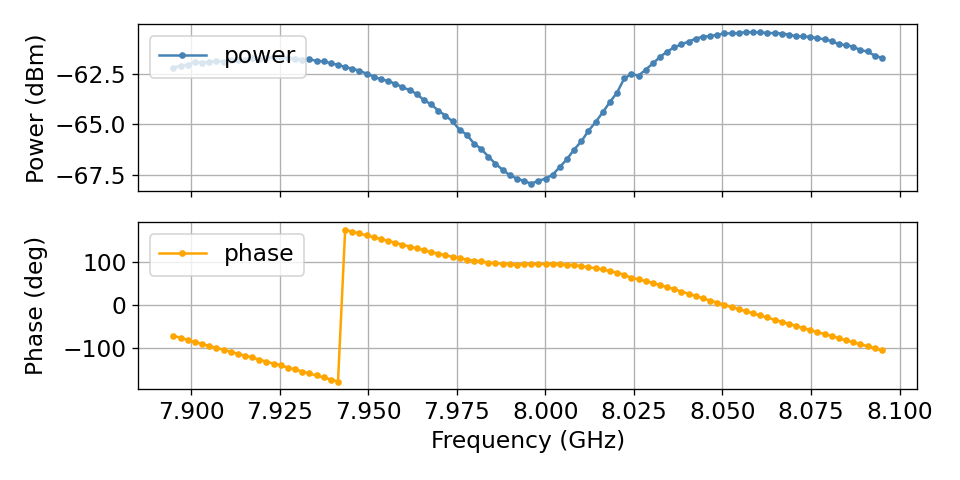

In [18]:
result = sweeper.run()
num_points_result = len(result["vector"])
print(f"Measured at {num_points_result} frequency points.")
plot_sweeper(np.linspace(ro_start_f, ro_stop_f, num_points) + ro_cent_f, result["vector"], unwrap = False, deg = True)
# sweeper.plot()
# plt.tight_layout()
# plt.show()

In [125]:
# list(sweeper)

## Pulsed output

### Measure total delay between pulse generation and integration

measured integration delay: 1240.0 ns


<IPython.core.display.Javascript object>


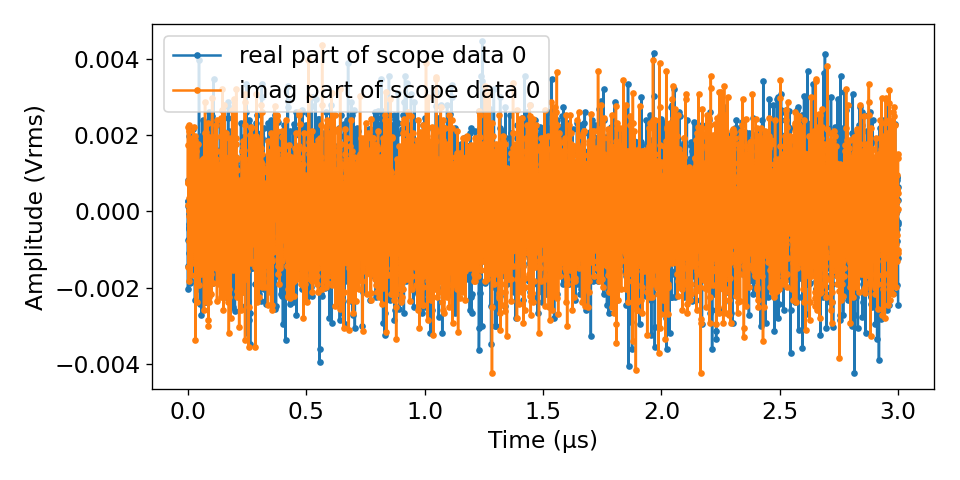

In [126]:
# configure scope 
scope_channel = 0
recording_time = envelope_duration + 1e-6

with device.set_transaction():
    device.qachannels[0].spectroscopy.envelope.enable(1)
    device.qachannels[0].spectroscopy.envelope.wave(flat_top_gaussian)
    
    device.scopes[0].trigger.enable(1)
    device.scopes[0].trigger.channel(32) 
    device.scopes[0].trigger.delay(0)        
    device.scopes[0].length(int(recording_time * fs))
    device.scopes[0].channels[scope_channel].inputselect(0)
    device.scopes[0].channels[scope_channel].enable(1)
    device.scopes[0].averaging.enable(0)
    device.scopes[0].segments.enable(0)
    device.qachannels[0].oscs[0].freq(230.4e6)
    device.qachannels[0].spectroscopy.trigger.channel(32)
    
     
seqc_program = f"""
    repeat(1) {{
        resetOscPhase(); 
        setTrigger(1); setTrigger(0);        
    }}
""" 
device.scopes[0].run(single = True)   
device.qachannels[0].generator.load_sequencer_program(seqc_program)
device.qachannels[0].generator.single(1)
device.qachannels[0].generator.enable(1)
scope_data, *_ = device.scopes[0].read()
integration_delay = int((np.argmin(np.diff(scope_data[0].real))+1)/4)*4/fs
print(f'measured integration delay: {integration_delay*1e9} ns')
plot_scope_data(scope_data, 0)

### Pulsed resonator spectroscopy

Run a sweep with 100 frequency points in the range of [-105.0, 95.0] MHz + 8.0 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (200000/200000) at -105.000MHz.                    
Measured at 100 frequency points.


<IPython.core.display.Javascript object>


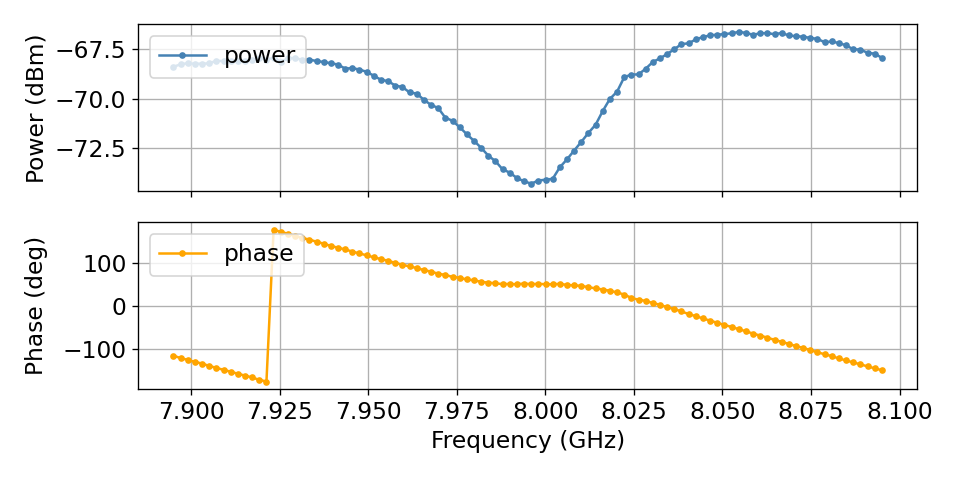

In [127]:
sweeper.envelope.enable(True)
sweeper.envelope.waveform(flat_top_gaussian)
sweeper.envelope.delay(envelope_delay)
sweeper.average.integration_delay(integration_delay)

# start measurement and plot
result = sweeper.run()
num_points_result = len(result["vector"])
print(f"Measured at {num_points_result} frequency points.")
plot_sweeper(np.linspace(ro_start_f, ro_stop_f, num_points) + ro_cent_f, result["vector"], unwrap = False, deg = True)
# sweeper.plot()
# plt.tight_layout()

## 2D sweep

### 2D sweep: frequency and amplitude of the digital oscillator (CW)

<IPython.core.display.Javascript object>


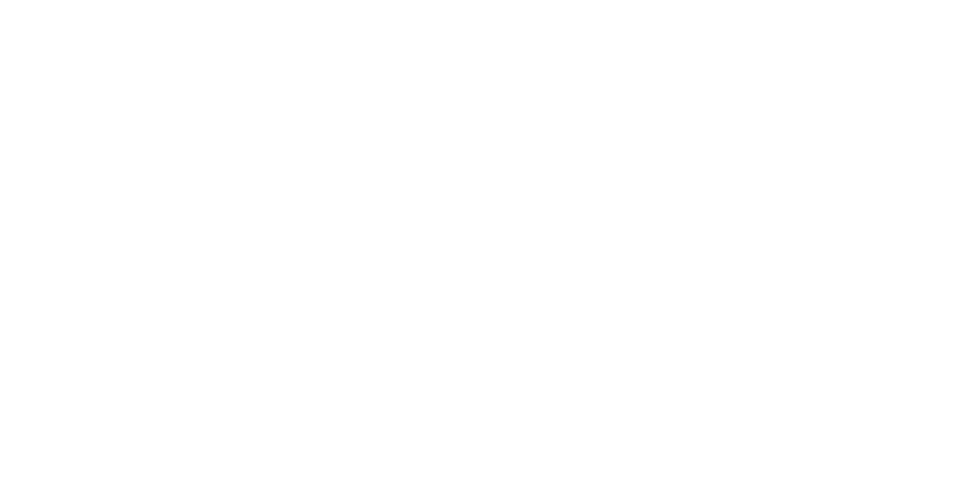

Run a sweep with 100 frequency points in the range of [-105.0, 95.0] MHz + 8.0 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (200000/200000) at -105.000MHz.                    
Run a sweep with 100 frequency points in the range of [-105.0, 95.0] MHz + 8.0 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (200000/200000) at -105.000MHz.                    
Run a sweep with 100 frequency points in the range of [-105.0, 95.0] MHz + 8.0 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Me

<IPython.core.display.Javascript object>


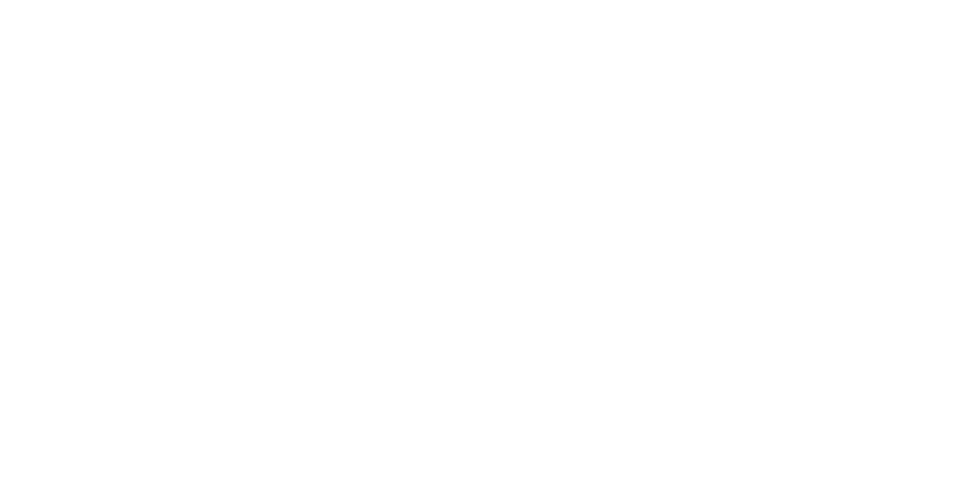

In [10]:
n = 3
ro_osc_gains = np.linspace(0.1, 1, n)

ro_f = np.linspace(ro_start_f, ro_stop_f, int(num_points)) + ro_cent_f
matrix = np.zeros([len(ro_osc_gains), num_points], dtype = np.complex_)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
for i in range(n):
    sweeper.envelope.enable(False)
    sweeper.sweep.oscillator_gain(ro_osc_gains[i])
    result = sweeper.run()
    matrix[i, :] = result['vector']
    
    ax0.plot(ro_f/1e9, 10*np.log10(np.abs(result['vector'])**2/50*1000), '.-', color = colors[i])
    ax1.plot(ro_f/1e9, np.angle(result['vector'], deg = True), '.-', color = colors[i])
    ax0.set_ylabel('Power (dBm)')
    ax1.set_ylabel('Phase (deg)')
    ax1.set_xlabel('Frequency (GHz)')
    ax0.grid()
    ax1.grid()
fig.tight_layout()
fig.align_ylabels([ax0, ax1])

plot_2d(ro_f/1e9, ro_osc_gains, matrix) 

### 2D sweep: frequency and amplitude of the digital oscillator (Pulsed)

<IPython.core.display.Javascript object>


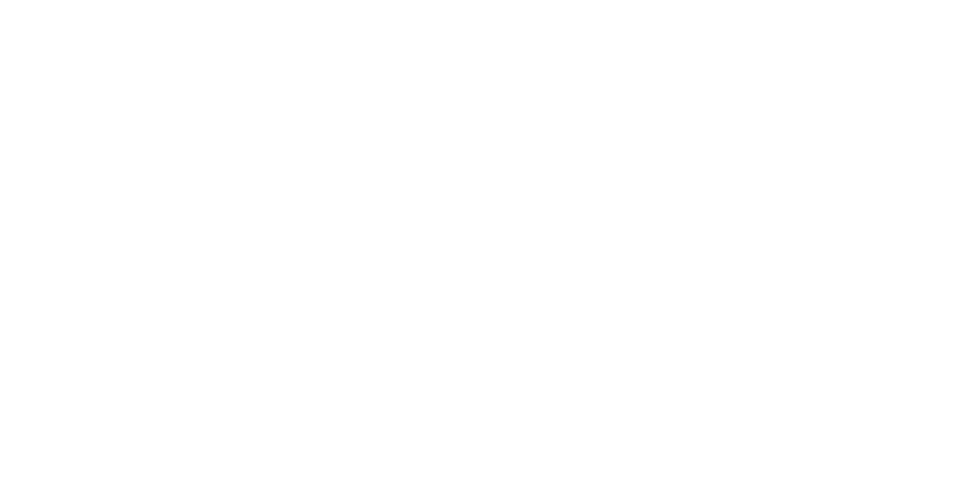

Run a sweep with 100 frequency points in the range of [-105.0, 95.0] MHz + 8.0 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (200000/200000) at -105.000MHz.                    
Run a sweep with 100 frequency points in the range of [-105.0, 95.0] MHz + 8.0 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Measurement (200000/200000) at -105.000MHz.                    
Run a sweep with 100 frequency points in the range of [-105.0, 95.0] MHz + 8.0 GHz. 
Mapping is linear. 
Integration time = 2e-06 sec. 
Measures 2000 times per frequency point. 
Averaging mode is cyclic.
Trigger source is set to None, which means the sequencer defines the repetition rate.
Me

<IPython.core.display.Javascript object>


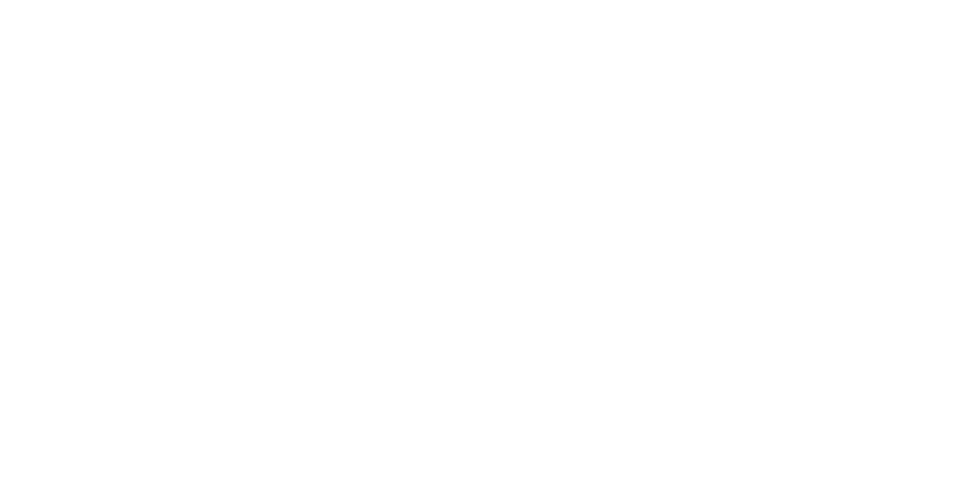

In [11]:
n = 3
ro_osc_gains = np.linspace(0.1, 1, n)

ro_f = np.linspace(ro_start_f, ro_stop_f, int(num_points)) + ro_cent_f
matrix = np.zeros([len(ro_osc_gains), num_points], dtype = np.complex_)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
for i in range(n):
    sweeper.envelope.enable(True)
    sweeper.sweep.oscillator_gain(ro_osc_gains[i])
    result = sweeper.run()
    matrix[i, :] = result['vector']
    
    ax0.plot(ro_f/1e9, 10*np.log10(np.abs(result['vector'])**2/50*1000), '.-', color = colors[i])
    ax1.plot(ro_f/1e9, np.angle(result['vector'], deg = True), '.-', color = colors[i])
    ax0.set_ylabel('Power (dBm)')
    ax1.set_ylabel('Phase (deg)')
    ax1.set_xlabel('Frequency (GHz)')
    ax0.grid()
    ax1.grid()
fig.tight_layout()
fig.align_ylabels([ax0, ax1])

plot_2d(ro_f/1e9, ro_osc_gains, matrix) 

# Qubit measurements (QA and SG channels)

## Set parameters

In [22]:
n_q = 2 # number of qubit

# ro_cent_f = 8e9 # range from 1 GHz - 8 GHz with 0.1 GHz granularity
ro_df = np.linspace(20e6, 50e6, n_q)
# ro_out_range = 0 # in dBm
# ro_in_range = 0  

ro_pulse_duration = envelope_duration # range from 0 - 2 us
ro_pulse_rise_fall_time = envelope_rise_fall_time
ro_pulse_phase = 0 # deg
weights_phase = 0
ro_pulse_amp = ro_osc_gain/n_q

integration_length = ro_pulse_duration
integration_delay = 228e-9
result_source = 1 # 1 integration, 3 thresholding
avg_mode = 0 # 0 cyclic, 1 sequential

dr_cent_f = np.linspace(5e9, 7e9, int(np.ceil(n_q/2)))
dr_df = np.ones(n_q) * 10e6
dr_out_range = np.ones(n_q) * 0
dr_pulse_duration = np.ones(n_q) * 200e-9
dr_pulse_sigma = dr_pulse_duration/2
dr_pulse_beta = np.ones(n_q) * 0.5
dr_pulse_amp = np.ones(n_q) * 0.5
n_cpmg = 5

with device.set_transaction():
    device.qachannels[0].centerfreq(ro_cent_f)
    device.qachannels[0].output.range(ro_out_range)
    device.qachannels[0].input.range(ro_in_range)
    device.qachannels[0].output.on(1)
    device.qachannels[0].input.on(1)
    
    device.qachannels[0].mode(1) # 0 spectroscopy, 1 readout
    device.qachannels[0].readout.integration.length(int(integration_length * fs)) # in samples
    device.qachannels[0].readout.integration.delay(int(integration_delay)) # in second
    device.qachannels[0].readout.result.source(result_source)
    device.qachannels[0].readout.result.mode(avg_mode) # 0 cyclic, 1 sequential
    device.qachannels[0].readout.result.enable(0) 
    device.qachannels[0].generator.auxtriggers[0].channel('inttrig')
    device.qachannels[0].generator.enable(0)
    ct = {}
    for i in range(n_q):
        device.synthesizers[int(np.floor(i/2) + 1)].centerfreq(dr_cent_f[int(np.floor(i/2))]) # synthesizer ind for sg_ch is from 1
        device.sgchannels[i].output.range(dr_out_range[i])
        device.sgchannels[i].output.on(1)
        device.sgchannels[i].oscs[0].freq(dr_df[i])
        device.sgchannels[i].sines[0].i.sin.amplitude(0)
        device.sgchannels[i].sines[0].i.cos.amplitude(1)
        device.sgchannels[i].sines[0].q.sin.amplitude(1)
        device.sgchannels[i].sines[0].q.cos.amplitude(0)
        device.sgchannels[i].sines[0].i.enable(0)
        device.sgchannels[i].sines[0].q.enable(0)
        device.sgchannels[i].awg.outputs[0].gains[0](1)
        device.sgchannels[i].awg.outputs[1].gains[0](1)
        device.sgchannels[i].awg.outputs[0].gains[1](-1)
        device.sgchannels[i].awg.outputs[1].gains[1](1)
        device.sgchannels[i].awg.time(0) # set 2.0 GSa/s for all channels
        ct_schema = device.sgchannels[i].awg.commandtable.load_validation_schema()
        ct[i] = CommandTable(ct_schema)
        
        device.sgchannels[i].trigger.level(0.1)
        device.sgchannels[i].awg.auxtriggers[0].slope(1)
        device.sgchannels[i].awg.auxtriggers[0].channel('inttrig')
                
device.qachannels[0].generator.clearwave()
readout_pulses = upload_generate_readout_pulses(device, ro_pulse_duration, ro_pulse_rise_fall_time, ro_df, ro_pulse_phase, n_q, ro_pulse_amp)


device.qachannels[0].readout.integration.clearweight()
weights = Waveforms()
for waveform_slot, pulse in readout_pulses.items():
    weights.assign_waveform(waveform_slot, np.conj(pulse[0]) * np.exp(2j * np.pi * weights_phase)/np.abs(pulse[0]))
device.qachannels[0].readout.write_integration_weights(weights = weights, integration_delay = integration_delay)


## Qubit spectroscopy

### Continuous drive


 wait at least 10.399999999999999 seconds
 progress: 100%

<IPython.core.display.Javascript object>


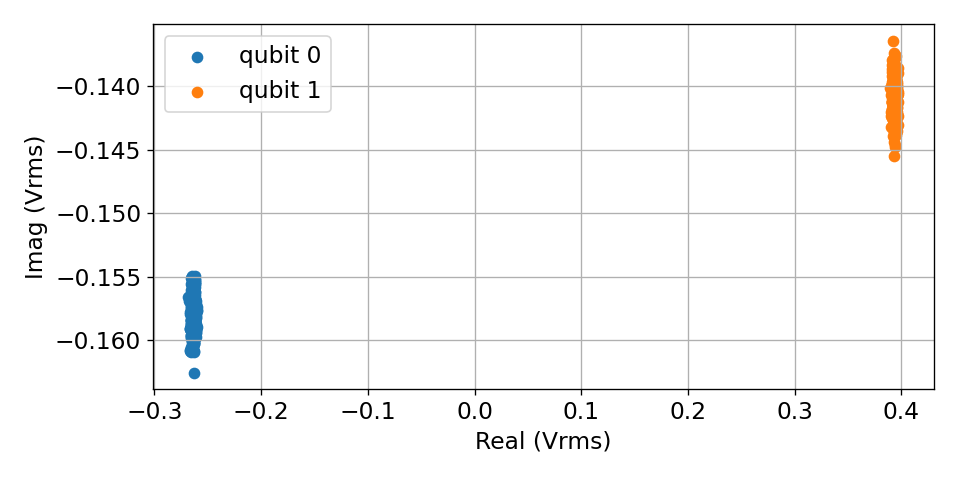

<IPython.core.display.Javascript object>


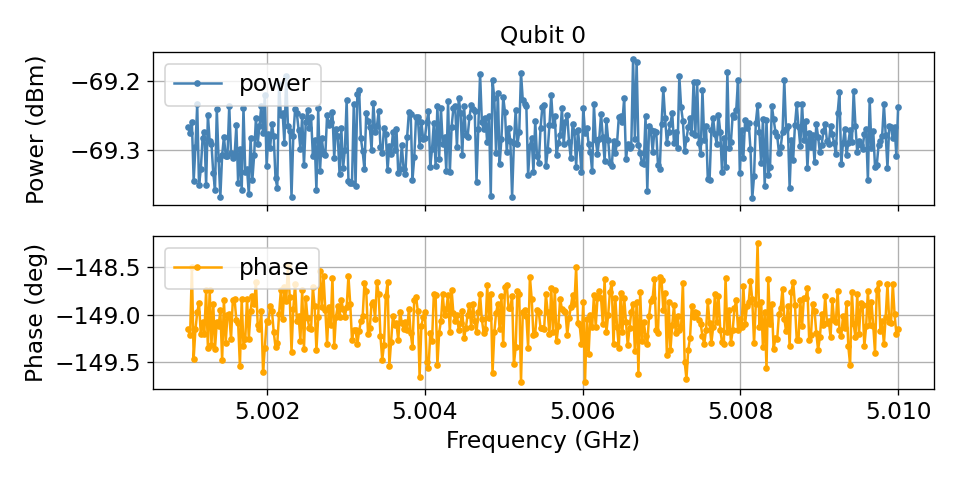

<IPython.core.display.Javascript object>


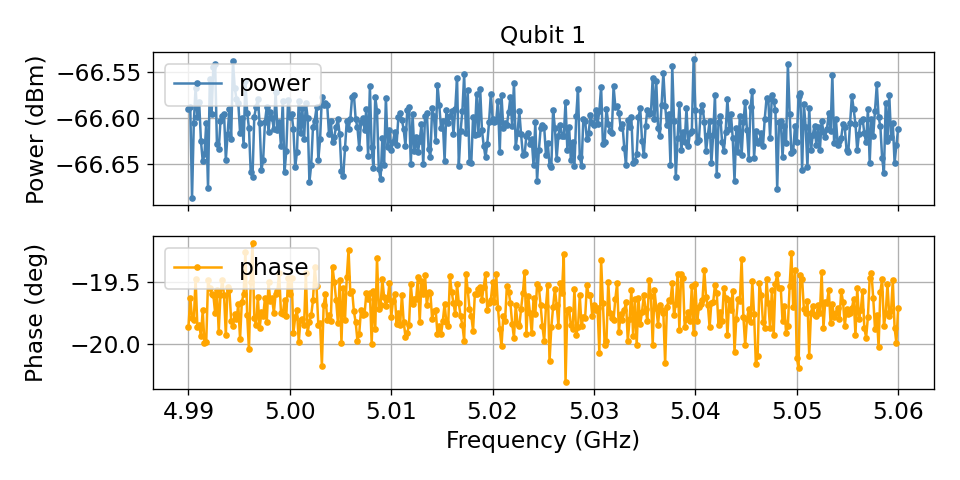

In [23]:
start = np.linspace(1e6, -10e6, n_q)
stop = np.linspace(10e6, 60e6, n_q)
num_points = 400
num_avgs = 5000
delay_after_trigger = max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 2e-6 # incease a bit the cycle time when num_repeat is larger
exp = 'qubit spec'
seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 
readout_results = []
with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)

    device.qachannels[0].readout.result.enable(1) # enable result logger
    for i in range(n_q):
        device.sgchannels[i].oscs[0].freq(start[i])
        device.sgchannels[i].sines[0].i.enable(1)
        device.sgchannels[i].sines[0].q.enable(1)
        device.sgchannels[i].sines[0].i.sin.amplitude(0)
        device.sgchannels[i].sines[0].i.cos.amplitude(dr_pulse_amp[i])
        device.sgchannels[i].sines[0].q.sin.amplitude(dr_pulse_amp[i])
        device.sgchannels[i].sines[0].q.cos.amplitude(0)
        upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                                   delay_after_trigger, n_cpmg, exp, True, device, i)
        device.sgchannels[i].awg.enable(1)
        
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))
    
device.system.internaltrigger.enable(1)
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')

progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points*num_avgs/1e6)

dr_f = np.zeros((n_q, num_points))
for i in range(n_q):
    dr_f[i] = np.linspace(start[i], stop[i], num_points) + dr_cent_f[int(np.floor(i/2))]
plot_readout_IQ(readout_results, n_q)
plot_qubit_readout_amp_phase(int(integration_length*fs), dr_f, readout_results[0:n_q], exp = exp)

### Pulsed drive


 wait at least 0.0832 seconds
 progress: 100%

<IPython.core.display.Javascript object>


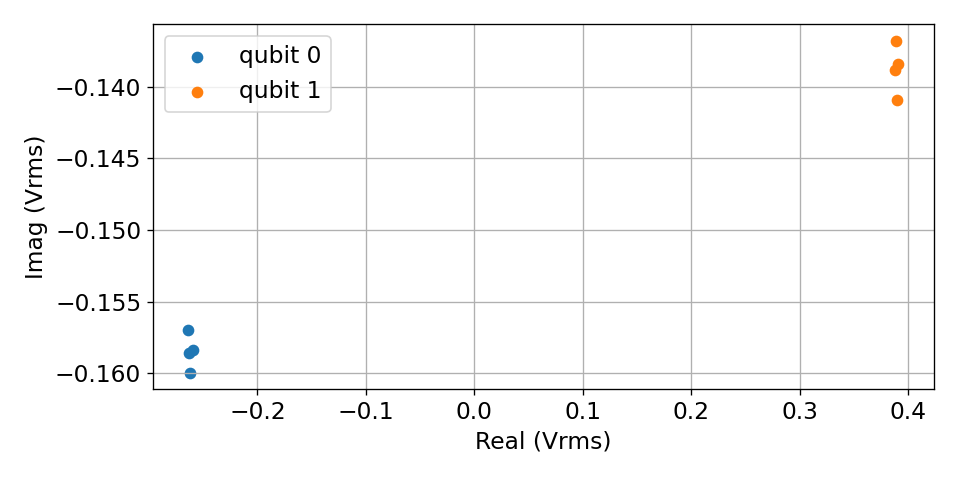

<IPython.core.display.Javascript object>


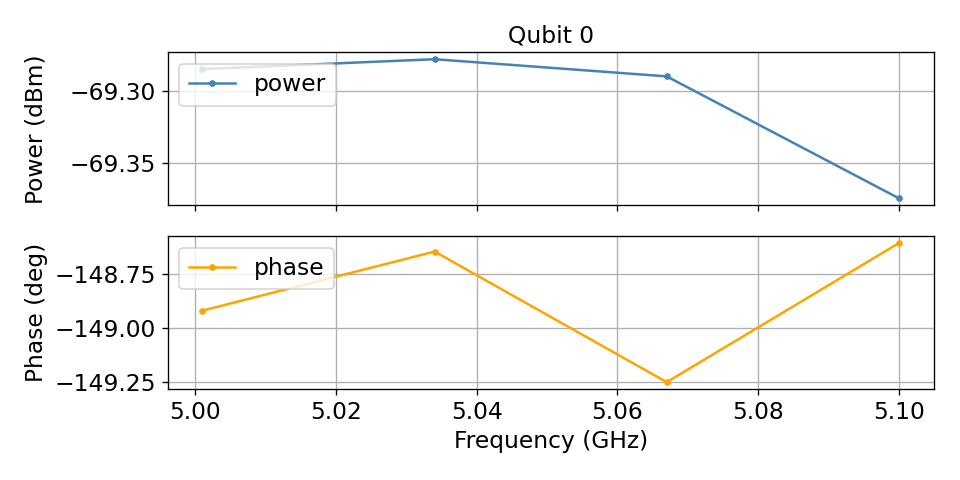

<IPython.core.display.Javascript object>


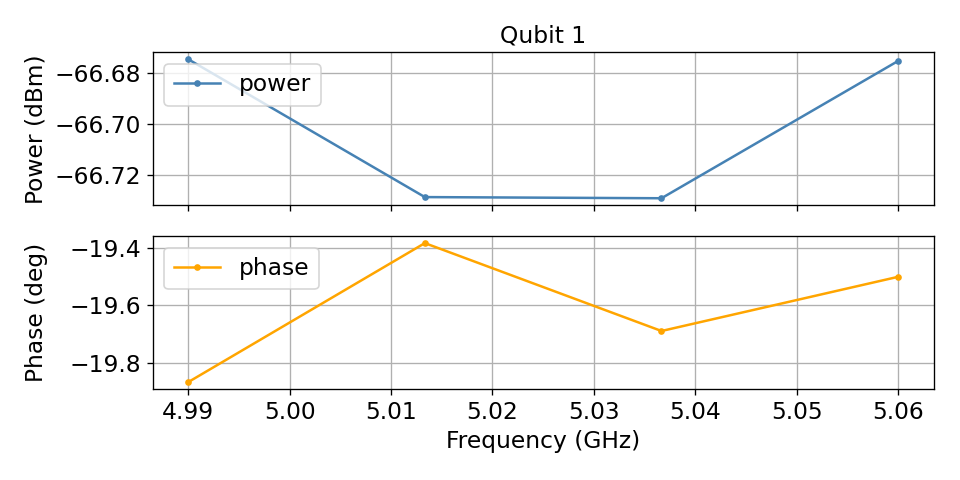

In [24]:
start = np.linspace(1e6, -10e6, n_q)
stop = np.linspace(100e6, 60e6, n_q)
num_points = 4
num_avgs = 4000
delay_after_trigger = max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 2e-6
exp = 'qubit spec pulsed'
# dr_pulse_amp = np.ones(n_q) * 1

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(start[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read()
dr_f = np.zeros((n_q, num_points))
for i in range(n_q):
    dr_f[i] = np.linspace(start[i], stop[i], num_points) + dr_cent_f[int(np.floor(i/2))]
plot_readout_IQ(readout_results, n_q)
plot_qubit_readout_amp_phase(int(integration_length*fs), dr_f, readout_results[0:n_q], exp = exp)

## Rabi

### Rabi (sweep amplitude)


 wait at least 0.0208 seconds
 progress: 100%

<IPython.core.display.Javascript object>


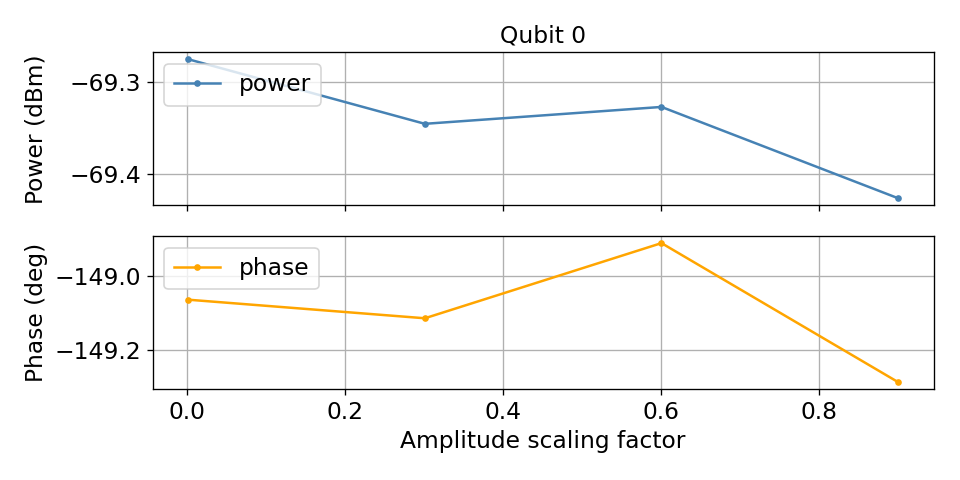

<IPython.core.display.Javascript object>


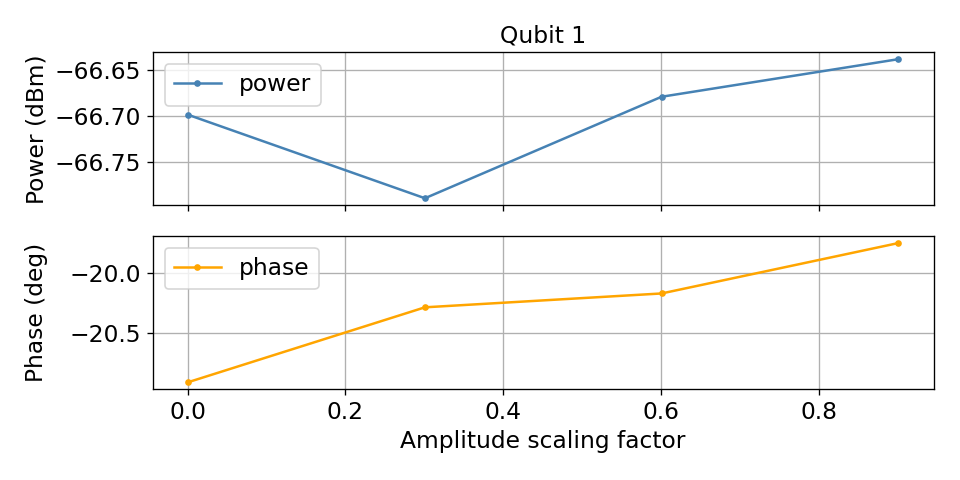

In [25]:
dr_df = np.ones(n_q) * 50e6 # qubit offset frequency
start = np.linspace(0.001, 0.001, n_q)
stop = np.linspace(0.9, 0.9, n_q)
num_points = 4
num_avgs = 1000
delay_after_trigger = max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 2e-6
exp = 'rabi da'
# dr_pulse_amp = np.ones(n_q) * 1

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(start[i], stop[i], num_points, exp, True, device, i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
dr_amp_sfactor = np.zeros([n_q, num_points])
for i in range(n_q):
    dr_amp_sfactor[i] = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs), dr_amp_sfactor, readout_results[0:n_q], exp = exp)

array([-0.26010009+0.06165636j, -0.25057085+0.05982986j,
       -0.2629343 +0.06278438j, -0.25982758+0.06807321j])

### Rabi (sweep duration)

start: 32.0 ns 
 stop: 272.00000000000006 ns 
 step: 80.0 ns

 wait at least 0.026176 seconds
 progress: 100%

<IPython.core.display.Javascript object>


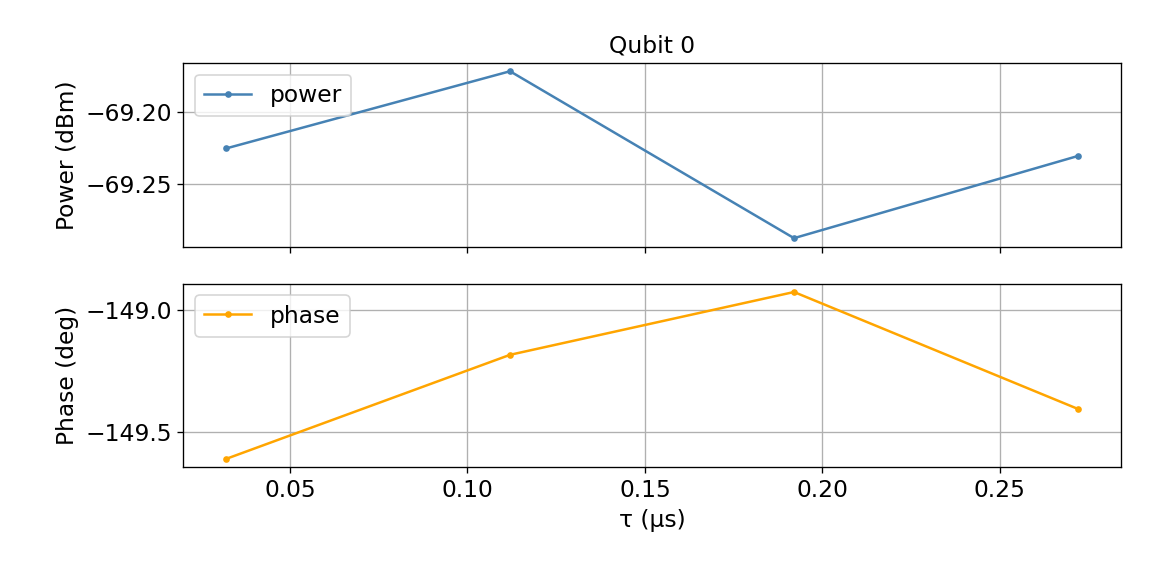

<IPython.core.display.Javascript object>


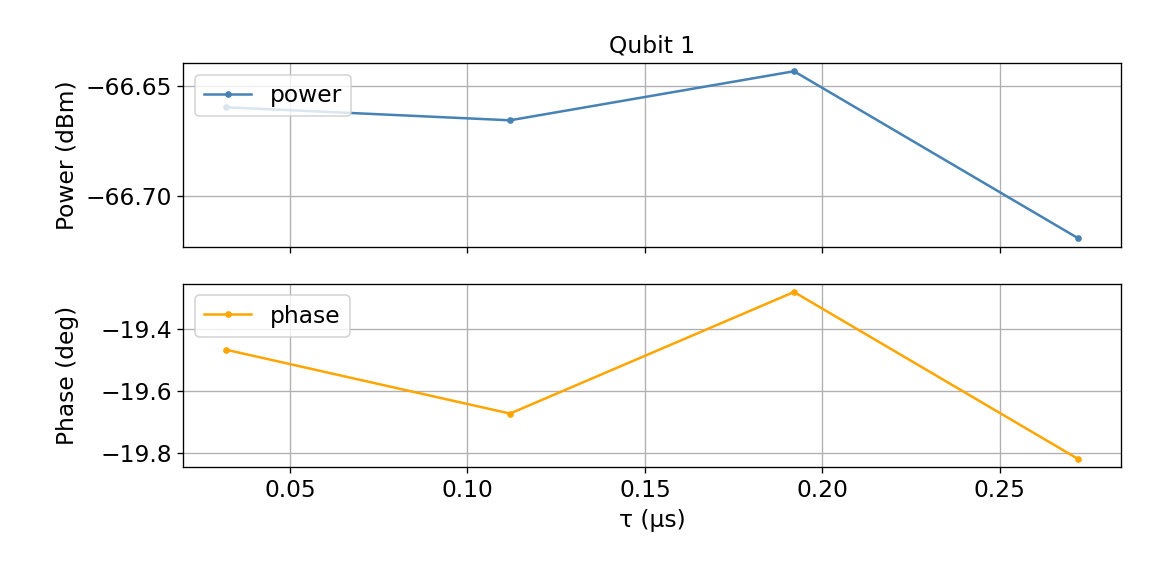

In [39]:
dr_df = np.ones(n_q) * 100e6
dr_pulse_amp = np.ones(n_q)
num_points = 4
num_avgs = 2000
step = 80e-9
start = np.linspace(32e-9, 32e-9, n_q)
stop = np.linspace(start[0] + step*(num_points-1), start[0] + step*(num_points-1), n_q)
print(f'start: {start[0]/1e-9} ns \n stop: {stop[0]/1e-9} ns \n step: {step/1e-9} ns')
delay_after_trigger = np.max(stop)
cycle_time = delay_after_trigger + ro_pulse_duration + 1e-6
exp = 'rabi dt'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 
readout_results = []
with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i, exp, start[i], stop[i], num_points)
    upload_ct_sg(start[i], stop[i], num_points, exp, True, device, i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read()
dr_amp_sfactor = np.zeros([n_q, num_points])
for i in range(n_q):
    dr_amp_sfactor[i] = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),dr_amp_sfactor, readout_results[0:n_q], exp = exp)

## T1 measurement

3 points, step 492.0 ns

 wait at least 0.0312 seconds
 progress: 100%

<IPython.core.display.Javascript object>


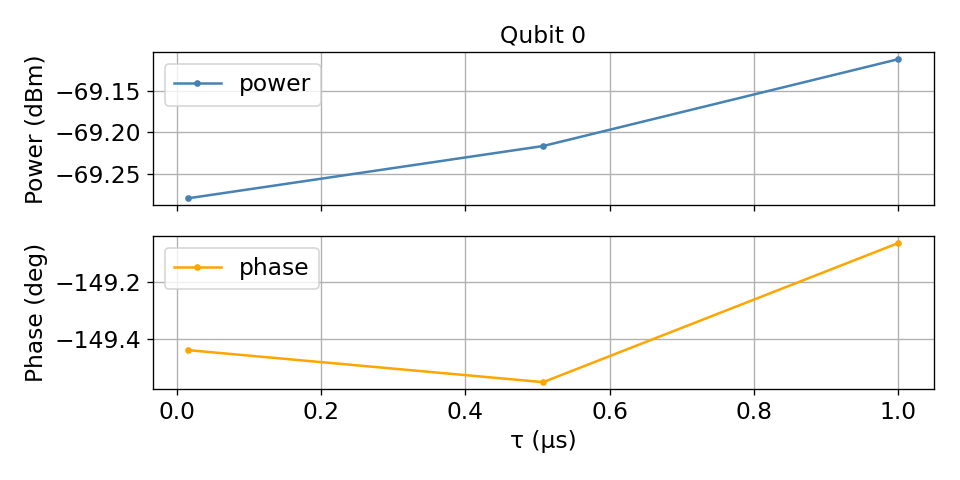

<IPython.core.display.Javascript object>


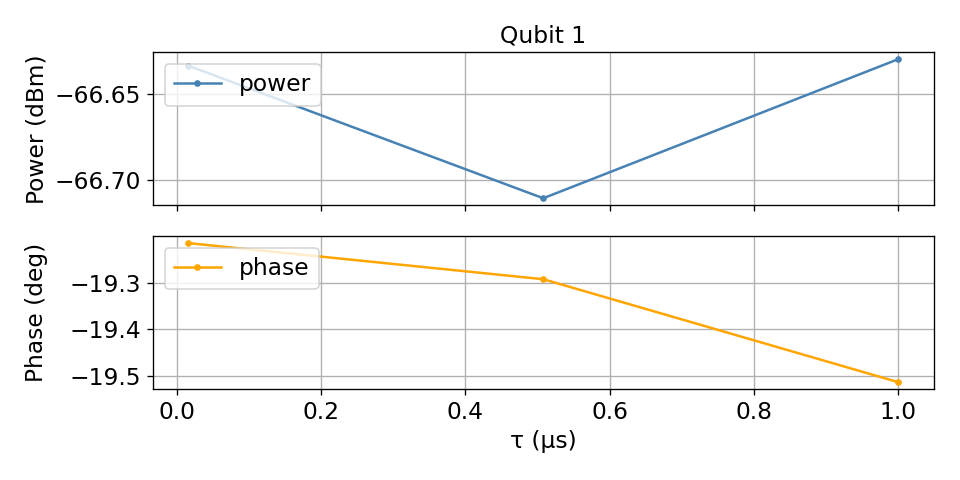

In [28]:
dr_pi_amp = np.ones(n_q) * 1 # pi pulse
dr_pulse_amp = dr_pi_amp 
dr_df = np.ones(n_q) * 50e6
start = np.ones(n_q) * 16e-9
stop = np.ones(n_q) * 1e-6
step = 8e-9 * 70
num_points = int(np.ceil(max(stop - start)/step + 1))
print(f'{num_points} points, step {max(stop-start)/(num_points-1)*1e9} ns')
num_avgs = 2000
delay_after_trigger = max(stop) + max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 1e-6
exp = 't1'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
x = np.zeros([n_q, num_points])
for i in range(n_q):
    x[i] = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),x, readout_results[0:n_q], exp = exp)

## T2 Measurement 

### T2 measurement (Ramsey)

3 points, step 492.0 ns

 wait at least 0.0324 seconds
 progress: 100%

<IPython.core.display.Javascript object>


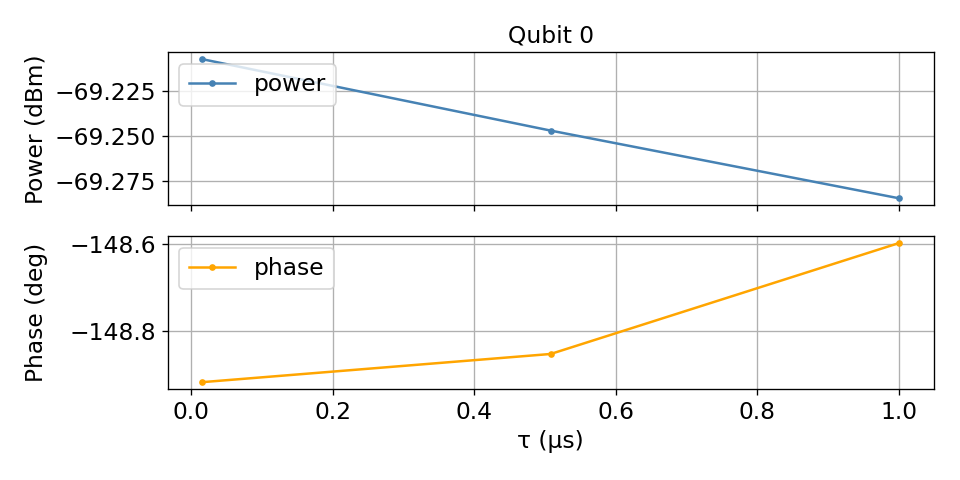

<IPython.core.display.Javascript object>


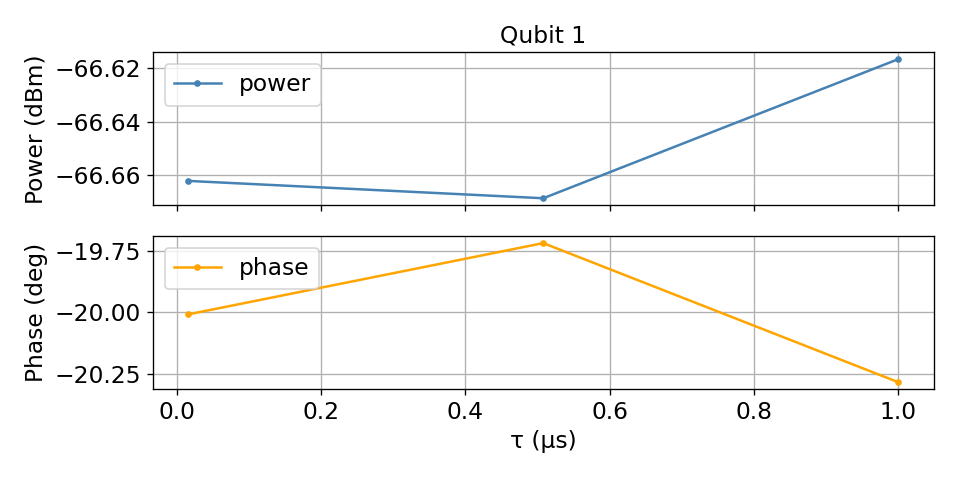

In [29]:
dr_pulse_amp = dr_pi_amp # pi/2 pulse is configured by command table with amplitude factor of 0.5
dr_df = np.ones(n_q) * 50e6
start = np.ones(n_q) * 16e-9
stop = np.ones(n_q) * 1e-6
step = 8e-9 * 70
num_points = int(np.ceil(max(stop - start)/step + 1))
print(f'{num_points} points, step {max(stop-start)/(num_points-1)*1e9} ns')
num_avgs = 2000
delay_after_trigger = max(stop) + 2 * max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 1e-6
exp = 'ramsey'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
x = np.zeros([n_q, num_points])
for i in range(n_q):
    x[i] = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),x, readout_results[0:n_q], exp = exp)

### T2 measurement (Hanh Echo)

3 points, step 492.0 ns

 wait at least 0.0336 seconds
 progress: 100%

<IPython.core.display.Javascript object>


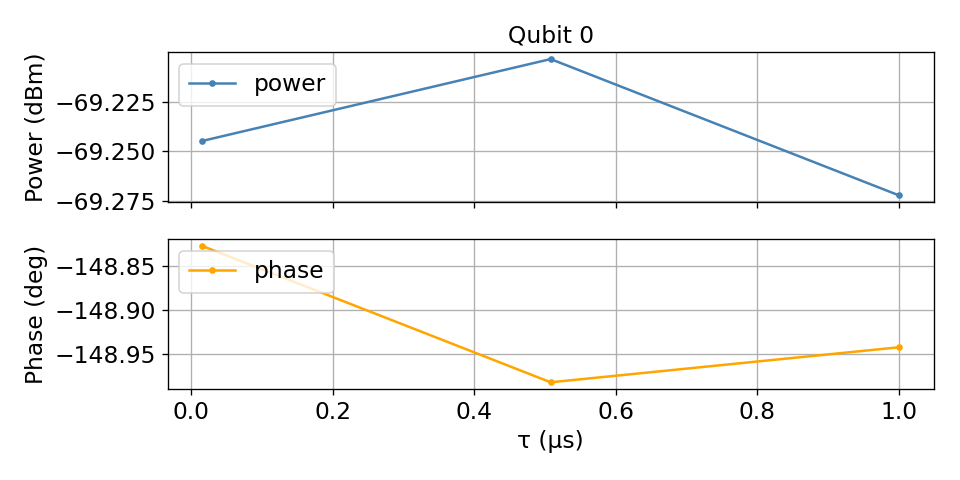

<IPython.core.display.Javascript object>


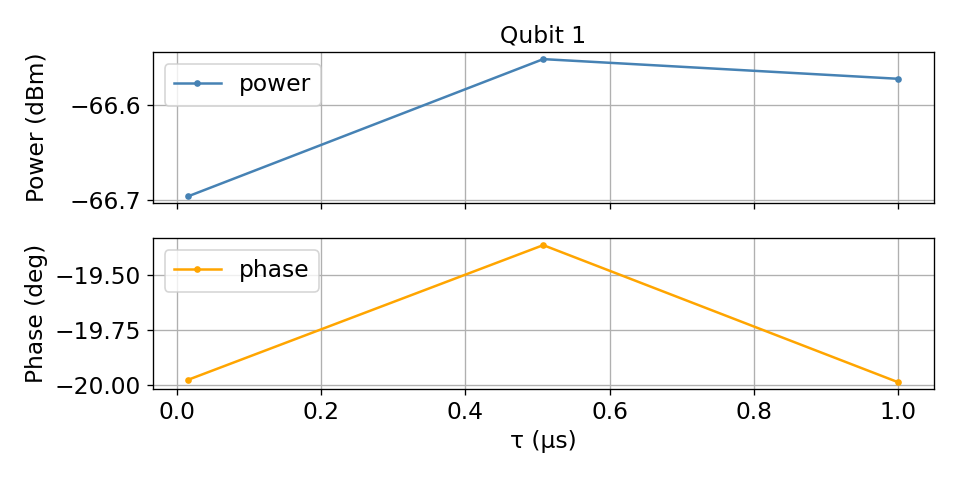

In [30]:
dr_pulse_amp = dr_pi_amp # pi/2 pulse is configured by command table with amplitude factor of 0.5
dr_df = np.ones(n_q) * 50e6
start = np.ones(n_q) * 16e-9
stop = np.ones(n_q) * 1e-6
step = 8e-9 * 70
num_points = int(np.ceil(max(stop - start)/step + 1))
print(f'{num_points} points, step {max(stop-start)/(num_points-1)*1e9} ns')
num_avgs = 2000
delay_after_trigger = 2 * max(stop) + 3 * max(dr_pulse_duration) + 0e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 1e-6
exp = 'hanh echo'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
x = np.zeros([n_q, num_points])
for i in range(n_q):
    x[i] = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),x, readout_results[0:n_q], exp = exp)

### T2 measurement (CPMG)

In [104]:
n_cpmg = 2
dr_pulse_amp = dr_pi_amp # pi/2 pulse is configured by command table with amplitude factor of 0.5
dr_df = np.ones(n_q) * 50e6
start = np.ones(n_q) * 16e-9
stop = np.ones(n_q) * 0.5e-6
step = 8e-9 * 40
num_points = int(np.ceil(max(stop - start)/step + 1))
print(f'{num_points} points, step {max(stop-start)/(num_points-1)*1e9} ns')
num_avgs = 2000
delay_after_trigger = 2 * n_cpmg * max(stop) + (n_cpmg+2) * max(dr_pulse_duration) + 0e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 0.2e-6
exp = 'cpmg'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
device.qachannels[0].generator.enable_sequencer(single=True) 

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.enable(1) # enable result logger
for i in range(n_q):
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
device.system.internaltrigger.holdoff(np.max(cycle_time))
device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
device.system.internaltrigger.enable(1)
    
print(f'\n wait at least {cycle_time*num_points*num_avgs} seconds')
progress = 0
while(progress<1):
    progress = device.system.internaltrigger.progress()
    sys.stdout.write(f'\r progress: {int(progress*100)}%')
    sys.stdout.flush()
    
readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
x = np.zeros([n_q, num_points])
for i in range(n_q):
    x[i] = np.linspace(start[i], stop[i], num_points)
plot_qubit_readout_amp_phase(int(integration_length*fs),x, readout_results[0:n_q], exp = exp)

3 points, step 241.99999999999997 ns

 wait at least 0.03 seconds
 progress: 100%

TimeoutError: The result logger is still running. This usually indicates that it did not receive the expected number of triggers.

## Discriminate state 

### Discriminate state (2-state only)

  #### Measure integration weights

<IPython.core.display.Javascript object>


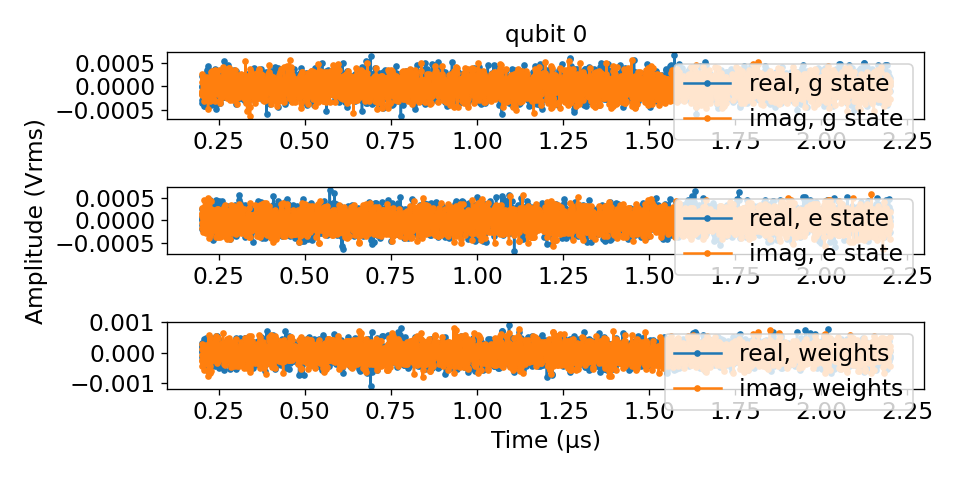

<IPython.core.display.Javascript object>


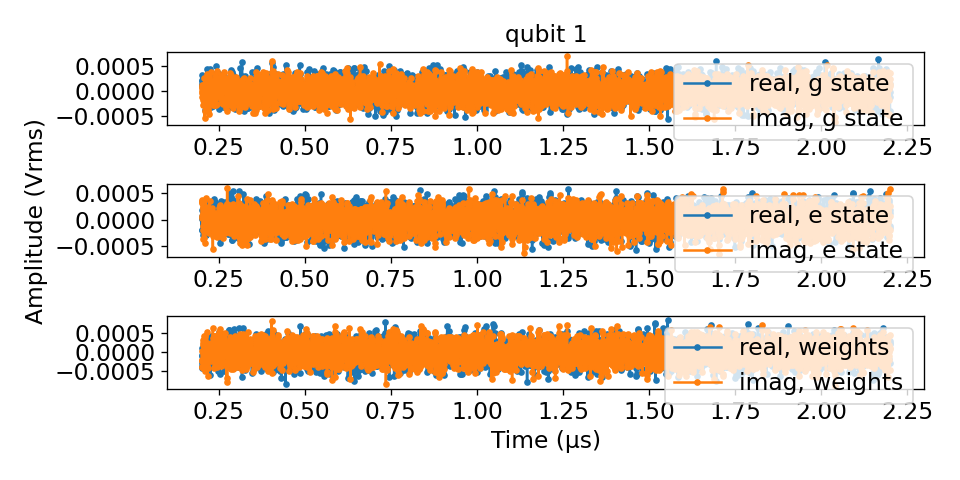

In [108]:
dr_pulse_amp = dr_pi_amp 
dr_df = np.ones(n_q) * 50e6 

num_points = 2 # 2-states
num_avgs = 50
delay_after_trigger = max(stop) + max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 4e-6
exp = 'weights 2-state'

scope_channel = 0
trigger_delay = 200e-9
device.scopes[scope_channel].configure(
    input_select={scope_channel: f"channel0_signal_input"},
    num_samples=int(ro_pulse_duration * fs/16)*16,
    trigger_input=f"chan0seqmon0",
    num_segments=num_points,
    num_averages=num_avgs,
    trigger_delay=trigger_delay,
)

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)

results = np.zeros((int(ro_pulse_duration * fs/16)*16, int(n_q)), dtype=np.complex128)
weights = Waveforms()
do_plot = 1
with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.mode(1) # 0 cyclic, 1 sequential
    device.qachannels[0].readout.result.source(1)
    device.qachannels[0].readout.result.enable(1) # enable result logger
    device.qachannels[0].generator.auxtriggers[0].channel(8)

for i in range(n_q):
    device.scopes[scope_channel].enable(0)
    device.sgchannels[i].oscs[0].freq(dr_df[i])
    device.sgchannels[i].sines[0].i.enable(0)
    device.sgchannels[i].sines[0].q.enable(0)
    device.sgchannels[i].awg.modulation.enable(1)
    device.qachannels[0].generator.enable_sequencer(single=True) 
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    
    device.scopes[scope_channel].run(single=True)
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
    device.system.internaltrigger.enable(1)

    scope_data, *_ = device.scopes[0].read()
    # Calculates the weights from scope measurements
    # for the excited and ground states
    split_data = np.split(scope_data[scope_channel], 2)
    ground_state_data = split_data[0]
    excited_state_data = split_data[1]
    x = np.linspace(trigger_delay, trigger_delay + len(scope_data[scope_channel])/2/fs, int(len(scope_data[scope_channel])/2))
    results[:,i]=np.conj(excited_state_data - ground_state_data)   
    weights.assign_waveform(i, np.conj(excited_state_data - ground_state_data))
    
    if do_plot is 1:
        fig, (ax0, ax1, ax2) = plt.subplots(3, 1)    
        ax0.plot(x/1e-6, ground_state_data.real, '.-', label = f'real, g state')
        ax0.plot(x/1e-6, ground_state_data.imag, '.-', label = f'imag, g state')    
        ax1.plot(x/1e-6, excited_state_data.real, '.-', label = f'real, e state')
        ax1.plot(x/1e-6, excited_state_data.imag, '.-', label = f'imag, e state')
        ax2.plot(x/1e-6, np.real(np.conj(excited_state_data - ground_state_data)), '.-', label = f'real, weights')
        ax2.plot(x/1e-6, np.imag(np.conj(excited_state_data - ground_state_data)), '.-', label = f'imag, weights')
        ax0.legend(loc='upper right')
        ax1.legend(loc='upper right')
        ax2.legend(loc='upper right')
        ax0.set_title(f'qubit {i}')
        ax2.set_xlabel('Time (μs)')
        ax1.set_ylabel('Amplitude (Vrms)')
        fig.align_ylabels()
        plt.tight_layout()
        plt.show()
        
# device.qachannels[0].readout.integration.clearweight()    
# device.qachannels[0].readout.write_integration_weights(weights)

#### Measure thresholds

<IPython.core.display.Javascript object>


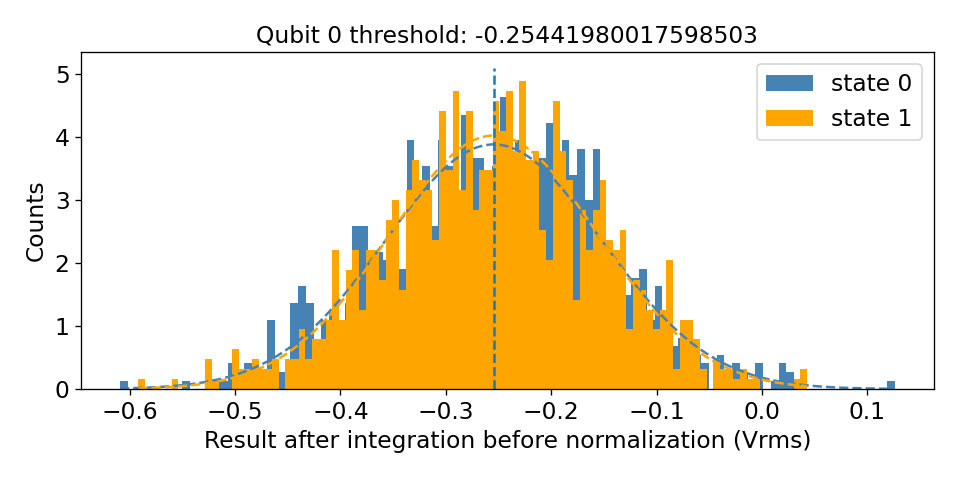

<IPython.core.display.Javascript object>


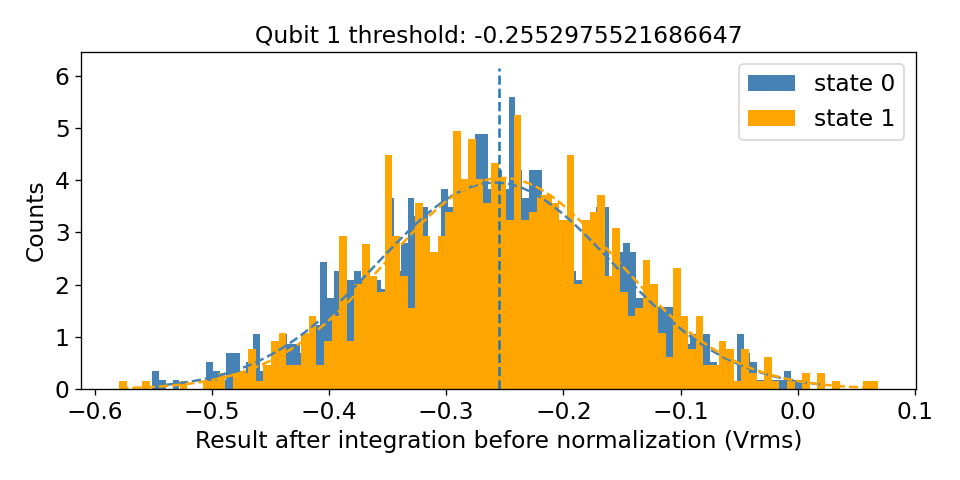

In [109]:
dr_pulse_amp = dr_pi_amp 

num_points = 2000 # 2-states
num_avgs = 1
delay_after_trigger = max(stop) + max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 3e-6
exp = 'thresholds 2-state'

seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)
 

results_results = np.zeros((num_points))
weights = Waveforms()
do_plot = 1
with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.source(1)
for i in range(n_q):
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    device.qachannels[0].readout.result.enable(1) # enable result logger
    device.qachannels[0].generator.enable_sequencer(single=True)
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
    device.system.internaltrigger.enable(1)

    readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
    threshold, mu_g, mu_g = plot_2_state_threshold_histogram(readout_results, num_bins = 100, ind_q = i)
    device.qachannels[0].readout.discriminators[i].threshold(threshold)
#     device.qachannels[0].readout.discriminators[i].threshold(10)

#### Discriminate states with random 0 or 1 state, and calculate assignment fidelity matrix

In [118]:
dr_pulse_amp = dr_pi_amp 
num_points = 2000 # 2-states
num_avgs = 1
delay_after_trigger = max(stop) + max(dr_pulse_duration) + 1e-6
cycle_time = delay_after_trigger + ro_pulse_duration + 3e-6
exp = 'assignment fidelity 2-state'

expected_results = np.zeros(num_points)
for i in range(num_points):
    if i%2 is not 0:
        expected_results[i] = 1       
        
seqc_qa = seqc_qubit_exp_qa(num_points, num_avgs, delay_after_trigger)
device.qachannels[0].generator.load_sequencer_program(seqc_qa)

results_results = np.zeros((num_points))
weights = Waveforms()
do_plot = 1
with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.source(3) # discrimination
for i in range(n_q):
    upload_compile_seqc_sg(start[i], stop[i], num_points, num_avgs, avg_mode, dr_pulse_duration[i], 
                                               delay_after_trigger, n_cpmg, exp, True, device, i)
    generate_upload_drive_drag_pulses(dr_pulse_duration[i], dr_pulse_sigma[i], dr_pulse_beta[i], 
                                                    dr_pulse_amp[i], True, device, i)
    upload_ct_sg(exp = exp, upload = True, device = device, channel_index = i)
    device.sgchannels[i].awg.enable(1)
    device.qachannels[0].readout.result.enable(1) # enable result logger
    device.qachannels[0].generator.enable_sequencer(single=True)
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
    device.system.internaltrigger.enable(1)

    readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
    matrix = calc_fidelity_matrix_2states(expected_results, readout_results[i], 2)  
    plot_fidelity_matrix(matrix, title=f'Qubit {i}')
 

IndexError: index 2 is out of bounds for axis 0 with size 2

## RB single qubit gate

Trigger connection:

- Marker output 1 to Trigger input 1A

In [116]:
n = 10 # Sequence length up to 65k
num_points = 10 # number of cycles, one cycle with one combinations
num_avgs = 2 # number of repeating 

pi_amplitude = 0.1
pi2_amplitude = pi_amplitude/2
pi_length = 40e-9
pi2_length = pi_length

wait_after_rb = 2e-6
cycle_time = wait_after_rb + pi_length*n*2

# generate complex waveforms (clifford_waves), and real and imaginary part (clifford_waves_real) of the waveforms 
(clifford_waves, clifford_waves_real) = generate_clifford_gates(pi_amplitude, pi_length, pi2_amplitude, pi2_length, 0)

# configure SHFQA and SHFSG for RB measurement 
upload_seqc_qa_rb(device, 0, num_points, num_avgs)

with device.set_transaction():
    device.qachannels[0].readout.result.length(num_points)
    device.qachannels[0].readout.result.averages(num_avgs)
    device.qachannels[0].readout.result.source(3) # discrimination
    device.qachannels[0].readout.result.mode(0) 
    device.qachannels[0].generator.auxtriggers[0].channel(0) # trigger input 1A

p_e = np.zeros((n, n_q))
for j in range(1,n+1):    
    for i in range(n_q):
        upload_seqc_sg_rb(device, i, clifford_waves, clifford_waves_real, num_points, num_avgs, wait_after_rb)
        upload_waveforms_sg_rb(device, i, clifford_waves_real)
        upload_ct_sg_rb(device, i, clifford_len=24, amp = 0.5)
        device.sgchannels[i].awg.enable(1)
        
    device.qachannels[0].readout.result.enable(1) # enable result logger
    device.qachannels[0].generator.enable_sequencer(single=True)
    device.system.internaltrigger.holdoff(np.max(cycle_time))
    device.system.internaltrigger.repetitions(int(num_points*num_avgs))   
    device.system.internaltrigger.enable(1)
    variation(device, np.linspace(0, n_q-1, n_q), j, clifford_len)
    readout_results = device.qachannels[0].readout.read(timeout = num_points/50)
    print(f'Update {int(j/n*100)}%', end='\r')
    p_e[j-1, :] = np.sum(readout_results[:2], axis = 1)/num_points
    
num_cliffords = np.linspace(1, n, n)
plot_population_vs_num_cliffords(num_cliffords, p_e)

TimeoutError: The result logger is still running. This usually indicates that it did not receive the expected number of triggers.